<a href="https://colab.research.google.com/github/sabbir394/grad-cam-based-coherence-regularised/blob/main/grad_cam_based_coherence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
 # Download the dataset
!kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset

# Unzip the dataset
!unzip -q the-iqothnccd-lung-cancer-dataset.zip -d lung_cancer_data

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes
Dataset URL: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset
License(s): CC0-1.0
 66% 98.0M/149M [00:00<00:00, 1.02GB/s]
100% 149M/149M [00:00<00:00, 804MB/s]  


In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-358fa7c1
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-358fa7c1
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=c127752733cff79127582b44e926e1d3a2d0e7fdce00ded5cc631b7e7b108e8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hxpbryy/wheels/16/9b/76/6e33fba6f1888d8c6e0faf79bb28198229cb8dfab1a502558d
Successfully built segmentation_models


In [ ]:
# === Full Baseline Cross-Entropy CNN Pipeline (No Coherence Regularization) ===

import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# === CLAHE Preprocessing ===
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return clahe.apply(img) if img is not None else None

# === Load Dataset ===
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
X, y = [], []
IMG_SIZE = 128

for subdir in subdirs:
    for path in glob(os.path.join(data_dir, subdir, "*.jpg")):
        img = apply_clahe(path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(subdir)

X = np.expand_dims(np.array(X).astype("float32") / 255.0, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)

# === Multi-Glimpse (Center Crop Only) ===
def center_crop(images, size):
    h, w = images.shape[1], images.shape[2]
    y, x = (h - size) // 2, (w - size) // 2
    return images[:, y:y+size, x:x+size, :]

GLIMPSE_SIZE = 124
X_train_crop = center_crop(X_train, GLIMPSE_SIZE)
X_test_crop = center_crop(X_test, GLIMPSE_SIZE)

# === CNN Model Definition ===
def build_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

# === Baseline training loop ===
def train_ce_only(model, optimizer, X_train, y_train, batch_size=32, epochs=30):
    for epoch in range(epochs):
        indices = np.arange(len(y_train))
        np.random.shuffle(indices)
        for i in range(0, len(y_train), batch_size):
            idx = indices[i:i+batch_size]
            x_batch = tf.convert_to_tensor(X_train[idx])
            y_batch = tf.convert_to_tensor(y_train[idx])
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, logits)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

# === Prediction & Accuracy Evaluation ===
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Baseline CNN Accuracy (CE only): {acc * 100:.2f}%")

# === MAIN ===
model_ce = build_base(GLIMPSE_SIZE, len(le.classes_))
optimizer = tf.keras.optimizers.Adam()
train_ce_only(model_ce, optimizer, X_train_crop, y_train)
evaluate(model_ce, X_test_crop, y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step

✅ Baseline CNN Accuracy (CE only): 99.09%


In [ ]:
# === Full Baseline Cross-Entropy CNN Pipeline (No Coherence Regularization) with Ensemble Extension ===

import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

# === CLAHE Preprocessing ===
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return clahe.apply(img) if img is not None else None

# === Load Dataset ===
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
X, y = [], []
IMG_SIZE = 128

for subdir in subdirs:
    for path in glob(os.path.join(data_dir, subdir, "*.jpg")):
        img = apply_clahe(path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(subdir)

X = np.expand_dims(np.array(X).astype("float32") / 255.0, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)

# === Multi-Glimpse (Center Crop Only) ===
def center_crop(images, size):
    h, w = images.shape[1], images.shape[2]
    y, x = (h - size) // 2, (w - size) // 2
    return images[:, y:y+size, x:x+size, :]

GLIMPSE_SIZE = 124
X_train_crop = center_crop(X_train, GLIMPSE_SIZE)
X_test_crop = center_crop(X_test, GLIMPSE_SIZE)

# === CNN Model Definition ===
def build_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

# === Baseline training loop ===
def train_ce_only(model, optimizer, X_train, y_train, batch_size=32, epochs=30):
    for epoch in range(epochs):
        indices = np.arange(len(y_train))
        np.random.shuffle(indices)
        for i in range(0, len(y_train), batch_size):
            idx = indices[i:i+batch_size]
            x_batch = tf.convert_to_tensor(X_train[idx])
            y_batch = tf.convert_to_tensor(y_train[idx])
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, logits)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

# === Prediction & Accuracy Evaluation ===
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Baseline CNN Accuracy (CE only): {acc * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# === SVD + Ensemble Evaluation ===
def ensemble_pipeline(model, X_train_crop, X_test_crop, y_train, y_test):
    feature_model = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
    X_train_feat = feature_model.predict(X_train_crop)
    X_test_feat = feature_model.predict(X_test_crop)

    svd = TruncatedSVD(n_components=64)
    X_train_svd = svd.fit_transform(X_train_feat)
    X_test_svd = svd.transform(X_test_feat)

    gnb = GaussianNB()
    svm = SVC(probability=True)
    rf = RandomForestClassifier()
    ensemble = VotingClassifier(estimators=[('rf', rf), ('svm', svm), ('nb', gnb)], voting='soft')
    ensemble.fit(X_train_svd, y_train)

    y_pred = ensemble.predict(X_test_svd)
    acc = accuracy_score(y_test, y_pred)
    y_prob = ensemble.predict_proba(X_test_svd)
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    auc = np.mean([roc_auc_score(y_bin[:, i], y_prob[:, i]) for i in range(y_bin.shape[1])])

    print(f"\n✅ Ensemble Accuracy (Baseline CNN Features): {acc * 100:.2f}%")
    print(f"Average AUC: {auc:.4f}")
    print("\nEnsemble Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# === MAIN ===
model_ce = build_base(GLIMPSE_SIZE, len(le.classes_))
optimizer = tf.keras.optimizers.Adam()
train_ce_only(model_ce, optimizer, X_train_crop, y_train)
evaluate(model_ce, X_test_crop, y_test)
ensemble_pipeline(model_ce, X_train_crop, X_test_crop, y_train, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

✅ Baseline CNN Accuracy (CE only): 99.09%

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.99      0.99      0.99        83

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.99       220
   weighted avg       0.99      0.99      0.99       220



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

✅ Ensemble Accuracy (Baseline CNN Features): 98.64%
Average AUC: 0.9991

Ensemble Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       0.98      1.00      0.99       113
   Normal cases       0.99      0.98      0.98        83

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.98       220
   weighted avg       0.99      0.99      0.99       220



In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# === CLAHE Preprocessing ===
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return clahe.apply(img) if img is not None else None

# === Load Dataset ===
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
X, y = [], []
IMG_SIZE = 128

for subdir in subdirs:
    for path in glob(os.path.join(data_dir, subdir, "*.jpg")):
        img = apply_clahe(path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(subdir)

X = np.expand_dims(np.array(X).astype("float32") / 255.0, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)

# === Multi-Glimpse Cropping ===
def multi_glimpses(images, size):
    h, w = images.shape[1], images.shape[2]
    positions = [(0, 0), (0, w-size), (h-size, 0), (h-size, w-size), ((h-size)//2, (w-size)//2)]
    return [images[:, y:y+size, x:x+size, :] for y, x in positions]

GLIMPSE_SIZE = 124
X_train_crops = multi_glimpses(X_train, GLIMPSE_SIZE)
X_test_crops = multi_glimpses(X_test, GLIMPSE_SIZE)

# === CNN Model ===
def build_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

base_model = build_base(GLIMPSE_SIZE, len(le.classes_))

print([layer.name for layer in base_model.layers])  # 🟢 Add this line here




['input_layer', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dropout', 'dense_1']


Epoch 1/30
Loss: Total=1.0006, CE=0.9992, Coherence=0.0137
Epoch 2/30
Loss: Total=0.5428, CE=0.5405, Coherence=0.0235
Epoch 3/30
Loss: Total=0.5773, CE=0.5735, Coherence=0.0382
Epoch 4/30
Loss: Total=0.2918, CE=0.2881, Coherence=0.0370
Epoch 5/30
Loss: Total=0.0953, CE=0.0927, Coherence=0.0267
Epoch 6/30
Loss: Total=0.2734, CE=0.2681, Coherence=0.0527
Epoch 7/30
Loss: Total=0.1593, CE=0.1555, Coherence=0.0383
Epoch 8/30
Loss: Total=0.0628, CE=0.0587, Coherence=0.0407
Epoch 9/30
Loss: Total=0.0406, CE=0.0355, Coherence=0.0510
Epoch 10/30
Loss: Total=0.0804, CE=0.0756, Coherence=0.0482
Epoch 11/30
Loss: Total=0.1735, CE=0.1701, Coherence=0.0347
Epoch 12/30
Loss: Total=0.0117, CE=0.0070, Coherence=0.0476
Epoch 13/30
Loss: Total=0.0085, CE=0.0020, Coherence=0.0653
Epoch 14/30
Loss: Total=0.0156, CE=0.0105, Coherence=0.0514
Epoch 15/30
Loss: Total=0.0089, CE=0.0041, Coherence=0.0484
Epoch 16/30
Loss: Total=0.0540, CE=0.0462, Coherence=0.0785
Epoch 17/30
Loss: Total=0.0161, CE=0.0107, Cohere

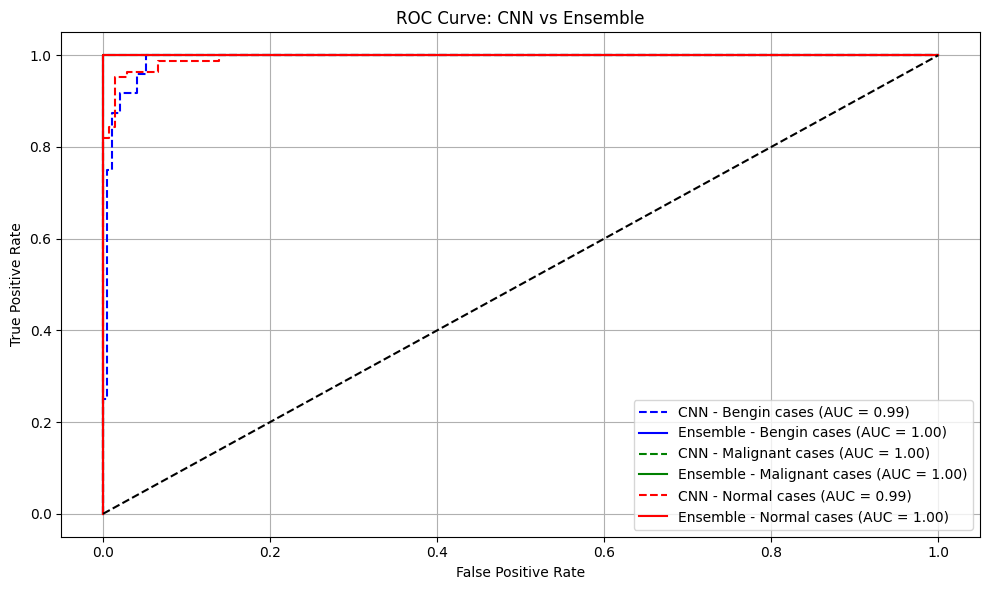

In [ ]:
# === Grad-CAM Tensor Function ===
def compute_gradcam_tensor(model, img, class_idx, layer_name="conv2d_2"):
    grad_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_output[0]), axis=-1)
    cam = tf.nn.relu(cam)
    cam /= tf.reduce_max(cam + 1e-8)
    return cam

# === Coherence Loss Function ===
def coherence_loss_fn(model, crops, labels, layer_name="conv2d_2"):
    batch_size = labels.shape[0]
    total_loss = 0.0

    for i in range(batch_size):
        sample_crops = [tf.expand_dims(crop[i], axis=0) for crop in crops]
        class_idx = labels[i]
        cams = []

        for crop_img in sample_crops:
            cam = compute_gradcam_tensor(model, crop_img, class_idx, layer_name)
            cam_resized = tf.image.resize(cam[..., tf.newaxis], [32, 32])
            cams.append(cam_resized)

        ref_cam = cams[-1]  # center
        sample_loss = tf.add_n([tf.reduce_mean(tf.abs(cam - ref_cam)) for cam in cams[:-1]])
        total_loss += sample_loss / (len(cams) - 1)

    return total_loss / tf.cast(batch_size, tf.float32)


# === Custom Training Loop ===
@tf.function
def train_step_with_coherence(model, optimizer, x_crops, y_true, lambda_coherence=0.1):
    with tf.GradientTape() as tape:
        logits = model(x_crops[-1], training=True)
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, logits)
        ce_loss = tf.reduce_mean(ce_loss)
        coh_loss = coherence_loss_fn(model, x_crops, y_true)
        total_loss = ce_loss + lambda_coherence * coh_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, ce_loss, coh_loss

# === Train with Coherence Regularization ===
optimizer = tf.keras.optimizers.Adam()
batch_size = 32
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    for i in range(0, len(y_train), batch_size):
        idx = indices[i:i+batch_size]
        crop_batch = [tf.convert_to_tensor(crop[idx]) for crop in X_train_crops]
        y_batch = tf.convert_to_tensor(y_train[idx])
        total_loss, ce_loss, coh_loss = train_step_with_coherence(base_model, optimizer, crop_batch, y_batch)
    print(f"Loss: Total={total_loss:.4f}, CE={ce_loss:.4f}, Coherence={coh_loss:.4f}")

# === Predict with Average Over Crops ===
def average_predictions(model, crops):
    preds = [model.predict(crop) for crop in crops]
    return np.mean(preds, axis=0)

y_test_probs = average_predictions(base_model, X_test_crops)
y_pred_dl = np.argmax(y_test_probs, axis=1)

# === Feature Extraction for ML Ensemble ===
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer(index=-3).output)
X_train_feat = feature_model.predict(X_train_crops[-1])
X_test_feat = feature_model.predict(X_test_crops[-1])

# === Dimensionality Reduction ===
svd = TruncatedSVD(n_components=64)
X_train_svd = svd.fit_transform(X_train_feat)
X_test_svd = svd.transform(X_test_feat)

# === Traditional ML Ensemble ===
gnb = GaussianNB()
svm = SVC(probability=True)
rf = RandomForestClassifier()
ensemble = VotingClassifier(estimators=[('rf', rf), ('svm', svm), ('nb', gnb)], voting='soft')
ensemble.fit(X_train_svd, y_train)
y_pred_ensemble = ensemble.predict(X_test_svd)

# === Evaluation Reports ===
print("=== CNN Softmax Report ===")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))
print("=== Ensemble Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))

# === ROC Curves ===
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

fpr_dl, tpr_dl, auc_dl = {}, {}, {}
for i in range(n_classes):
    fpr_dl[i], tpr_dl[i], _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
    auc_dl[i] = roc_auc_score(y_test_bin[:, i], y_test_probs[:, i])

y_proba_ensemble = ensemble.predict_proba(X_test_svd)
fpr_ens, tpr_ens, auc_ens = {}, {}, {}
for i in range(n_classes):
    fpr_ens[i], tpr_ens[i], _ = roc_curve(y_test_bin[:, i], y_proba_ensemble[:, i])
    auc_ens[i] = roc_auc_score(y_test_bin[:, i], y_proba_ensemble[:, i])

plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i, cls in enumerate(le.classes_):
    plt.plot(fpr_dl[i], tpr_dl[i], linestyle='--', color=colors[i], label=f'CNN - {cls} (AUC = {auc_dl[i]:.2f})')
    plt.plot(fpr_ens[i], tpr_ens[i], linestyle='-', color=colors[i], label=f'Ensemble - {cls} (AUC = {auc_ens[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CNN vs Ensemble')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_cnn_ensemble.png")
plt.show()


=== CNN Softmax Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.91      0.83      0.87        24
Malignant cases       0.97      1.00      0.99       113
   Normal cases       0.96      0.95      0.96        83

       accuracy                           0.96       220
      macro avg       0.95      0.93      0.94       220
   weighted avg       0.96      0.96      0.96       220

=== Ensemble Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      1.00      1.00        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       1.00      1.00      1.00        83

       accuracy                           1.00       220
      macro avg       1.00      1.00      1.00       220
   weighted avg       1.00      1.00      1.00       220



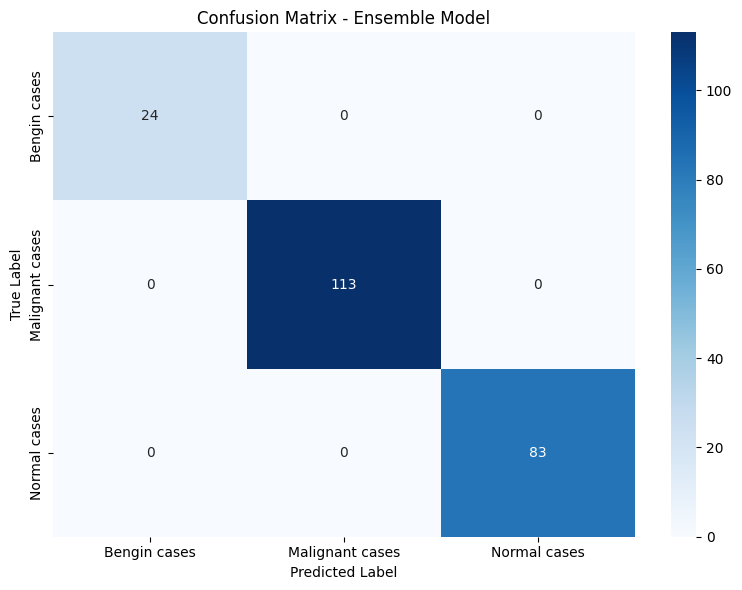

In [ ]:
# Add these imports at the beginning of your code
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Evaluation Reports ===
print("=== CNN Softmax Report ===")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))
print("=== Ensemble Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))

# === Confusion Matrix for Ensemble ===
plt.figure(figsize=(8, 6))
conf_mat = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("confusion_matrix_ensemble.png")
plt.show()

# === ROC Curves ===


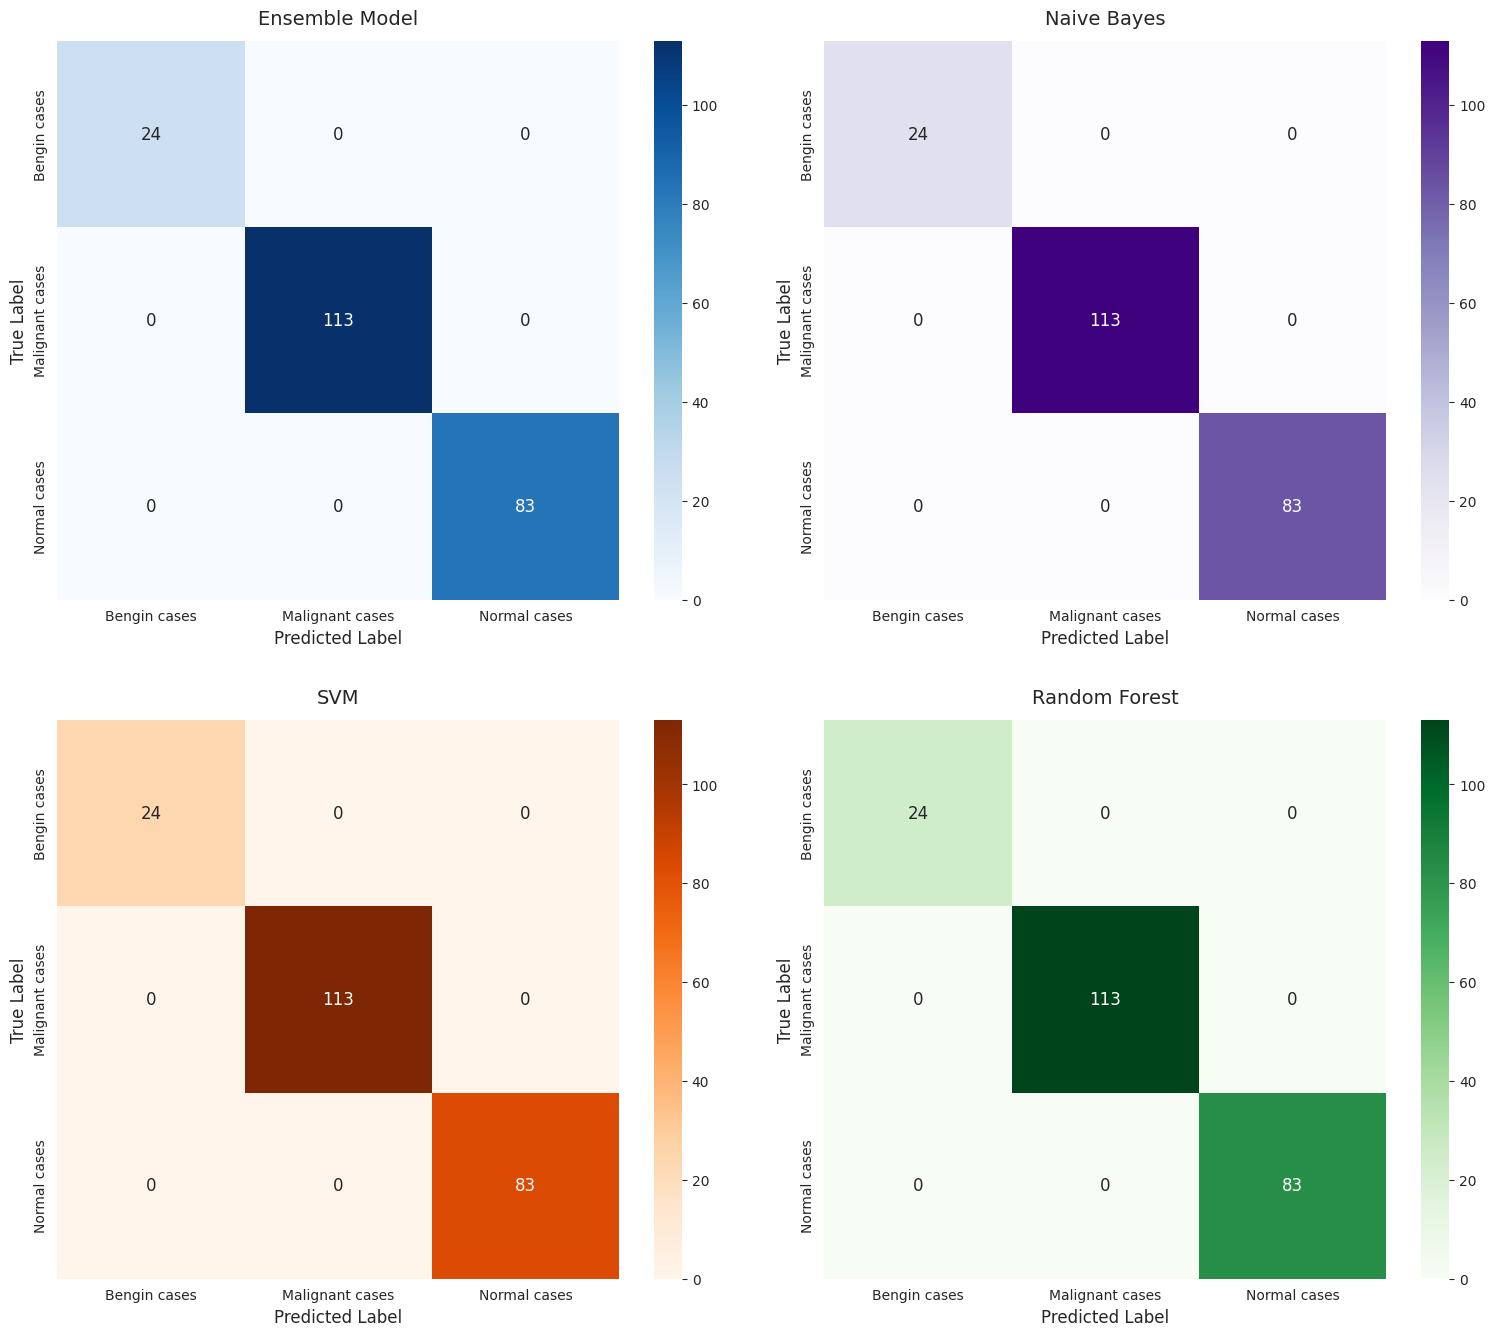

=== CNN Softmax Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.91      0.83      0.87        24
Malignant cases       0.97      1.00      0.99       113
   Normal cases       0.96      0.95      0.96        83

       accuracy                           0.96       220
      macro avg       0.95      0.93      0.94       220
   weighted avg       0.96      0.96      0.96       220


=== Ensemble Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      1.00      1.00        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       1.00      1.00      1.00        83

       accuracy                           1.00       220
      macro avg       1.00      1.00      1.00       220
   weighted avg       1.00      1.00      1.00       220


=== Naive Bayes Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      1.00      1.00        24
M

In [ ]:
# Import required libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure with 2x2 subplots
plt.figure(figsize=(16, 14))

# 1. Ensemble Model Confusion Matrix (Top Left)
plt.subplot(2, 2, 1)
conf_mat_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(conf_mat_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('Ensemble Model', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# 2. Naive Bayes Confusion Matrix (Top Right)
plt.subplot(2, 2, 2)
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_mat_nb, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('Naive Bayes', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# 3. SVM Confusion Matrix (Bottom Left)
plt.subplot(2, 2, 3)
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('SVM', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# 4. Random Forest Confusion Matrix (Bottom Right)
plt.subplot(2, 2, 4)
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('Random Forest', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Adjust layout and save
plt.tight_layout(pad=3.0)
plt.savefig("all_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

# Print classification reports
print("=== CNN Softmax Report ===")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))
print("\n=== Ensemble Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))
print("\n=== Naive Bayes Report ===")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))
print("\n=== SVM Report ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))
print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

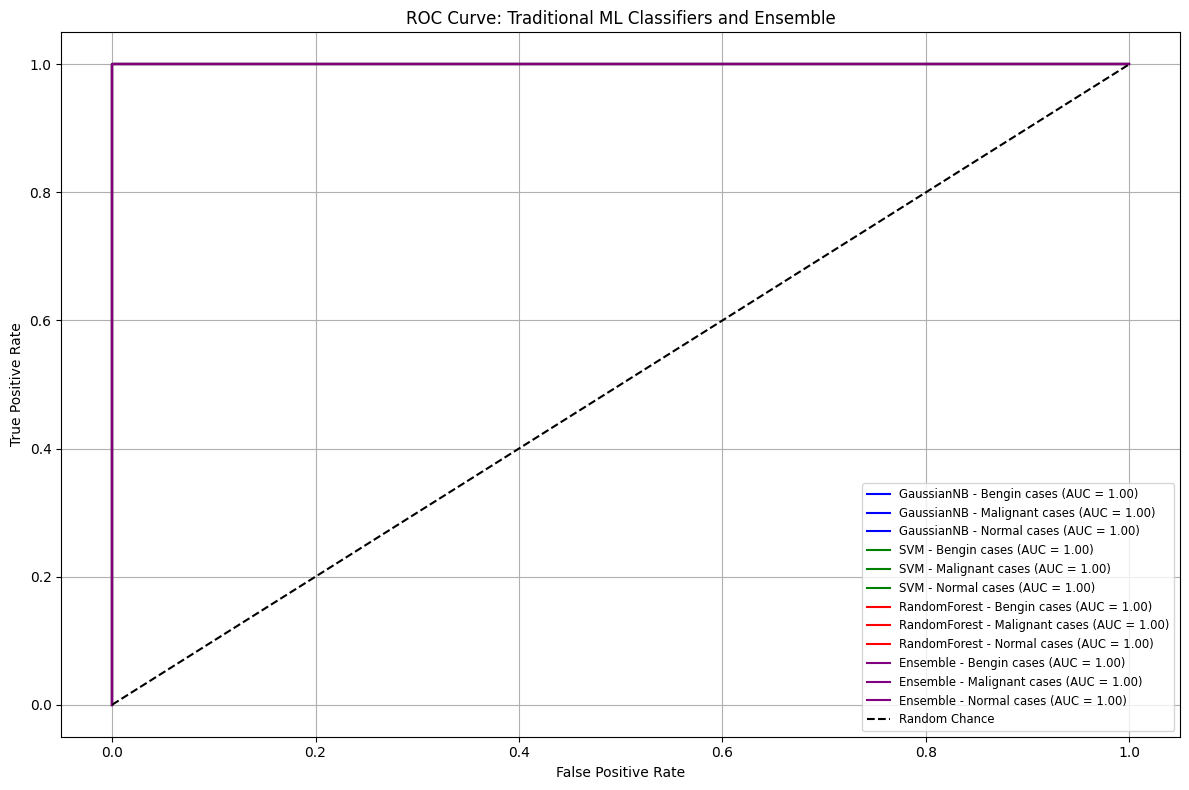

In [ ]:
# === Fit individual ML models ===
gnb.fit(X_train_svd, y_train)
svm.fit(X_train_svd, y_train)
rf.fit(X_train_svd, y_train)

# === ROC Curves: Traditional ML Classifiers & Ensemble ===
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

ml_models = {
    'GaussianNB': gnb,
    'SVM': svm,
    'RandomForest': rf,
    'Ensemble': ensemble
}

roc_data = {}
for name, model in ml_models.items():
    y_proba = model.predict_proba(X_test_svd)
    fpr, tpr, auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        auc[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    roc_data[name] = (fpr, tpr, auc)

# === Plot ROC Curves ===
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']
for idx, (name, (fpr, tpr, auc)) in enumerate(roc_data.items()):
    for i, cls in enumerate(le.classes_):
        plt.plot(fpr[i], tpr[i], linestyle='-', color=colors[idx],
                 label=f'{name} - {cls} (AUC = {auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Traditional ML Classifiers and Ensemble')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_ml_ensemble.png")
plt.show()


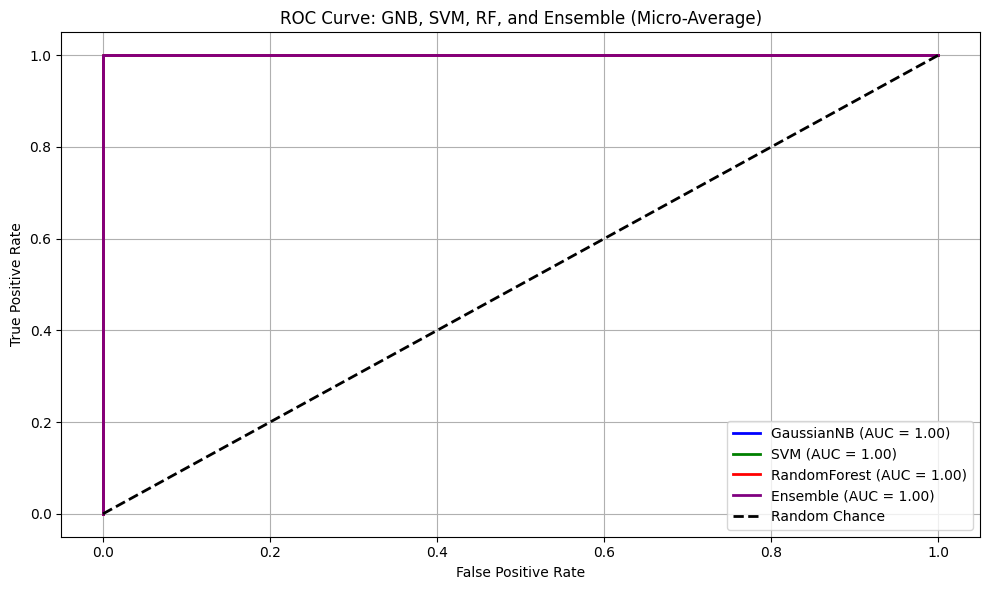

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Fit individual models
gnb.fit(X_train_svd, y_train)
svm.fit(X_train_svd, y_train)
rf.fit(X_train_svd, y_train)

# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Dictionary of models
ml_models = {
    'GaussianNB': gnb,
    'SVM': svm,
    'RandomForest': rf,
    'Ensemble': ensemble
}

# ROC computation (micro-average)
roc_data = {}
for name, model in ml_models.items():
    y_score = model.predict_proba(X_test_svd)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple']
for idx, (name, (fpr, tpr, roc_auc)) in enumerate(roc_data.items()):
    plt.plot(fpr, tpr, color=colors[idx], lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GNB, SVM, RF, and Ensemble (Micro-Average)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_ml_ensemble_microavg.png")
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cnn_fpr_all, cnn_tpr_all, cnn_auc_all = [], [], []
ens_fpr_all, ens_tpr_all, ens_auc_all = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train_crops[-1], y_train)):
    print(f"\n====== Fold {fold+1}/5 ======")

    # Split crops for each fold
    X_train_fold_crops = [crop[train_idx] for crop in X_train_crops]
    X_test_fold_crops = [crop[test_idx] for crop in X_train_crops]
    y_train_fold = y_train[train_idx]
    y_test_fold = y_train[test_idx]

    # Reinitialize and train model
    model = tf.keras.models.clone_model(base_model)
    model.set_weights(base_model.get_weights())
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(epochs):
        for i in range(0, len(y_train_fold), batch_size):
            idx = np.arange(len(y_train_fold))[i:i+batch_size]
            crop_batch = [tf.convert_to_tensor(crop[idx]) for crop in X_train_fold_crops]
            y_batch = tf.convert_to_tensor(y_train_fold[idx])
            train_step_with_coherence(model, optimizer, crop_batch, y_batch)

    # Evaluate CNN
    fpr_cnn, tpr_cnn, auc_cnn = evaluate_cnn(model, X_test_fold_crops, y_test_fold, le, title_suffix=f"Fold {fold+1}")
    cnn_fpr_all.append(fpr_cnn)
    cnn_tpr_all.append(tpr_cnn)
    cnn_auc_all.append(auc_cnn)

    # Feature extraction & SVD
    feature_model = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
    X_train_feat = feature_model.predict(X_train_fold_crops[-1])
    X_test_feat = feature_model.predict(X_test_fold_crops[-1])

    svd = TruncatedSVD(n_components=64)
    X_train_svd = svd.fit_transform(X_train_feat)
    X_test_svd = svd.transform(X_test_feat)

    # Ensemble
    ensemble = VotingClassifier(estimators=[('rf', RandomForestClassifier()), ('svm', SVC(probability=True)), ('nb', GaussianNB())], voting='soft')
    ensemble.fit(X_train_svd, y_train_fold)
    fpr_ens, tpr_ens, auc_ens = evaluate_ensemble(X_test_svd, y_test_fold, ensemble, le, title_suffix=f"Fold {fold+1}")
    ens_fpr_all.append(fpr_ens)
    ens_tpr_all.append(tpr_ens)
    ens_auc_all.append(auc_ens)



====== Fold 1/5 ======


ValueError: in user code:

    File "/tmp/ipython-input-4-1788433247.py", line 46, in train_step_with_coherence  *
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 383, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 422, in apply
        self.build(trainable_variables)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/adam.py", line 97, in build
        self.add_variable_from_reference(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 35, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 319, in add_variable_from_reference
        return self.add_variable(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 274, in add_variable
        variable = backend.Variable(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/common/variables.py", line 186, in __init__
        self._initialize_with_initializer(initializer)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/core.py", line 47, in _initialize_with_initializer
        self._initialize(lambda: initializer(self._shape, dtype=self._dtype))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/core.py", line 38, in _initialize
        self._value = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


/tmp/ipython-input-21-3436528951.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


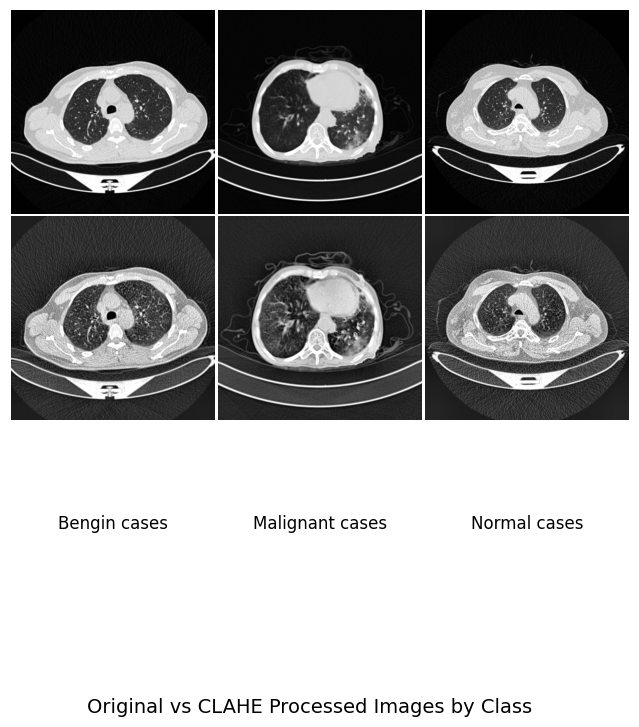

In [ ]:
# === Display Original vs CLAHE Processed Images ===
plt.figure(figsize=(8, 8))

# Select 3 classes to display
display_classes = le.classes_[:3] if len(le.classes_) >= 3 else le.classes_

# Create a grid: 3 rows (original, CLAHE, labels), 3 columns (one per class)
grid = plt.GridSpec(3, 3, hspace=0.01, wspace=0.01)

for i, class_name in enumerate(display_classes):
    # Get first image path for this class
    class_path = os.path.join(data_dir, class_name)
    img_path = glob(os.path.join(class_path, "*.jpg"))[0]

    # Load images
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    clahe_img = apply_clahe(img_path)

    # Original images (first row)
    plt.subplot(grid[0, i])
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original", size=12, rotation=0, ha='right', va='center')

    # CLAHE images (second row)
    plt.subplot(grid[1, i])
    plt.imshow(clahe_img, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("CLAHE", size=12, rotation=0, ha='right', va='center')

    # Class names (third row)
    plt.subplot(grid[2, i])
    plt.text(0.5, 0.5, class_name,
             ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.suptitle("Original vs CLAHE Processed Images by Class", y=.02, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Compact Python code implementing the 5 key improvements
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# CLAHE preprocessing
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return clahe.apply(img) if img is not None else None

# Load dataset
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
X, y = [], []
IMG_SIZE = 128

for subdir in subdirs:
    for path in glob(os.path.join(data_dir, subdir, "*.jpg")):
        img = apply_clahe(path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(subdir)

X = np.expand_dims(np.array(X).astype("float32") / 255.0, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)

# Multi-glimpse attention
def multi_glimpses(images, size):
    h, w = images.shape[1], images.shape[2]
    positions = [(0, 0), (0, w-size), (h-size, 0), (h-size, w-size), ((h-size)//2, (w-size)//2)]
    return [images[:, y:y+size, x:x+size, :] for y, x in positions]

GLIMPSE_SIZE = 124
X_train_crops = multi_glimpses(X_train, GLIMPSE_SIZE)
X_test_crops = multi_glimpses(X_test, GLIMPSE_SIZE)

# CNN model
def build_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

base_model = build_base(GLIMPSE_SIZE, len(le.classes_))
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train on center crop
base_model.fit(X_train_crops[-1], y_train, epochs=30, batch_size=32, validation_split=0.2)

# Average ensemble of predictions across crops
def average_predictions(model, crops):
    preds = [model.predict(crop) for crop in crops]
    return np.mean(preds, axis=0)

y_test_probs = average_predictions(base_model, X_test_crops)
y_pred_dl = np.argmax(y_test_probs, axis=1)

# Grad-CAM visualization utility
def save_gradcam(img, model, layer_name, class_idx, filename):
    grad_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(np.expand_dims(img, 0))
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_output[0]), axis=-1)
    heatmap = tf.maximum(cam, 0) / tf.reduce_max(cam)
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(np.uint8(img * 255), cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)
    cv2.imwrite(filename, overlay)

# Extract features for traditional ML
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer(index=-3).output)
X_train_feat = feature_model.predict(X_train_crops[-1])
X_test_feat = feature_model.predict(X_test_crops[-1])

# Reduce dimensionality
svd = TruncatedSVD(n_components=64)
X_train_svd = svd.fit_transform(X_train_feat)
X_test_svd = svd.transform(X_test_feat)

# ML Ensemble
gnb = GaussianNB()
svm = SVC(probability=True)
rf = RandomForestClassifier()
ensemble = VotingClassifier(estimators=[('rf', rf), ('svm', svm), ('nb', gnb)], voting='soft')
ensemble.fit(X_train_svd, y_train)
y_pred_ensemble = ensemble.predict(X_test_svd)

# Evaluation
print("=== CNN Softmax Report ===")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))
print("=== Ensemble Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))

# Save Grad-CAM for first 3 samples
for i in range(3):
    save_gradcam(X_test_crops[-1][i], base_model, 'conv2d_2', y_pred_dl[i], f"gradcam_{i}.png")


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 504ms/step - accuracy: 0.5263 - loss: 0.9661 - val_accuracy: 0.6818 - val_loss: 0.7857
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step - accuracy: 0.6524 - loss: 0.8037 - val_accuracy: 0.7841 - val_loss: 0.5682
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step - accuracy: 0.7839 - loss: 0.5378 - val_accuracy: 0.8693 - val_loss: 0.3654
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - accuracy: 0.8193 - loss: 0.4271 - val_accuracy: 0.7955 - val_loss: 0.4727
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 486ms/step - accuracy: 0.8455 - loss: 0.3805 - val_accuracy: 0.8636 - val_loss: 0.3022
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy: 0.8994 - loss: 0.2241 - val_accuracy: 0.9034 - val_loss: 0.2068
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - accuracy: 0.9274 - loss: 0.2032 - val_accuracy: 0.9602 - val_loss: 0.1606
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.9694 - loss: 0.1111 - val_accu

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step
=== CNN Softmax Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.67      0.80        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.91      0.99      0.95        83

       accuracy                           0.96       220
      macro avg       0.97      0.88      0.91       220
   weighted avg       0.96      0.96      0.96       220

=== Ensemble Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.96      1.00      0.98        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       1.00      0.99      0.99        83

       accuracy                           

In [ ]:
# Updated code with:
# - kNN and Gradient Boosting added to ensemble
# - 5-fold cross-validation
# - ROC curves, confusion matrices
# - Accuracy/Loss curves
# - Grad-CAM image generation fixed

import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# CLAHE preprocessing
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return clahe.apply(img) if img is not None else None

# Load dataset
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
X, y = [], []
IMG_SIZE = 128

for subdir in subdirs:
    for path in glob(os.path.join(data_dir, subdir, "*.jpg")):
        img = apply_clahe(path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(subdir)

X = np.expand_dims(np.array(X).astype("float32") / 255.0, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Multi-glimpse attention
def multi_glimpses(images, size):
    h, w = images.shape[1], images.shape[2]
    positions = [(0, 0), (0, w-size), (h-size, 0), (h-size, w-size), ((h-size)//2, (w-size)//2)]
    return [images[:, y:y+size, x:x+size, :] for y, x in positions]

GLIMPSE_SIZE = 124
X_crops = multi_glimpses(X, GLIMPSE_SIZE)

# CNN model
def build_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, 3, activation='relu', padding='same', name='conv1')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same', name='conv3')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

# Grad-CAM visualizer
def save_gradcam(img, model, layer_name, class_idx, filename):
    grad_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(np.expand_dims(img, 0))
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_output[0]), axis=-1)
    heatmap = tf.maximum(cam, 0) / tf.reduce_max(cam)
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(np.uint8(img * 255), cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)
    cv2.imwrite(filename, overlay)

# K-Fold training
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_idx, test_idx in kf.split(X, y_encoded):
    print(f"\n=== Fold {fold} ===")
    X_train_crops = [crop[train_idx] for crop in X_crops]
    X_test_crops = [crop[test_idx] for crop in X_crops]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    model = build_base(GLIMPSE_SIZE, len(le.classes_))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_crops[-1], y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Accuracy/Loss Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"fold_{fold}_acc_loss.png")
    plt.close()

    # Grad-CAM save
    for i in range(3):
        save_gradcam(X_test_crops[-1][i], model, 'conv3', y_test[i], f"gradcam_fold{fold}_{i}.png")

    # DL prediction
    y_probs_dl = np.mean([model.predict(crop[test_idx]) for crop in X_crops], axis=0)
    y_pred_dl = np.argmax(y_probs_dl, axis=1)

    print("Deep Learning Report:")
    print(classification_report(y_test, y_pred_dl, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred_dl)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"conf_matrix_fold_{fold}.png")
    plt.close()

    # ROC Curve (only for binary/multiclass OvR)
    if len(le.classes_) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_probs_dl[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
        plt.savefig(f"roc_fold_{fold}.png")
        plt.close()

    # ML pipeline
    feat_model = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
    X_train_feat = feat_model.predict(X_train_crops[-1])
    X_test_feat = feat_model.predict(X_test_crops[-1])

    svd = TruncatedSVD(n_components=64)
    X_train_svd = svd.fit_transform(X_train_feat)
    X_test_svd = svd.transform(X_test_feat)

    classifiers = {
        "GNB": GaussianNB(),
        "SVM": SVC(probability=True),
        "RF": RandomForestClassifier(),
        "GBM": GradientBoostingClassifier(),
        "KNN": KNeighborsClassifier()
    }

    for name, clf in classifiers.items():
        clf.fit(X_train_svd, y_train)
        y_pred = clf.predict(X_test_svd)
        print(f"\n{name} Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Voting Ensemble
    ensemble = VotingClassifier(estimators=[
        ('rf', classifiers["RF"]),
        ('svm', classifiers["SVM"]),
        ('nb', classifiers["GNB"]),
        ('gbm', classifiers["GBM"]),
        ('knn', classifiers["KNN"])
    ], voting='soft')
    ensemble.fit(X_train_svd, y_train)
    y_pred_ensemble = ensemble.predict(X_test_svd)
    print("\nEnsemble Report:")
    print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))





=== Fold 1 ===
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Deep Learning Report:
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        24
Malignant cases       0.93      1.00      0.97       113
   Normal cases       0.78      0.93      0.85        83

       accuracy                           0.86       220
      macro avg       0.57      0.64      0.60       220
   weighted avg       0.77      0.86      0.82       220



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step

GNB Report:
                 precision    recall  f1-score   support

   Bengin cases       0.57      0.50      0.53        24
Malignant cases       0.95      1.00      0.97       113
   Normal cases       0.85      0.82      0.83        83

       accuracy                           0.88       220
      macro avg       0.79      0.77      0.78       220
   weighted avg       0.87      0.88      0.87       220


SVM Report:
                 precision    recall  f1-score   support

   Bengin cases       0.40      0.08      0.14        24
Malignant cases       0.97      0.99      0.98       113
   Normal cases       0.78      0.94      0.85        83

       accuracy                           0.87       220
      macro avg       0.72      0.67      0.66       220
   weighted avg       0.84      0.87      0.84       220


RF Report:
                 precision    recall  f1-score   support

   Bengin cases     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

GNB Report:
                 precision    recall  f1-score   support

   Bengin cases       0.73      0.79      0.76        24
Malignant cases       0.99      1.00      1.00       112
   Normal cases       0.94      0.90      0.92        84

       accuracy                           0.94       220
      macro avg       0.89      0.90      0.89       220
   weighted avg       0.94      0.94      0.94       220


SVM Report:
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.78      1.00      0.88        84

       accuracy                           0.89       220
      macro avg       0.59      0.67      0.62       220
   weighted avg       0.81      0.89      0.84       220



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



RF Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.92      0.96        24
Malignant cases       0.99      1.00      1.00       112
   Normal cases       0.98      0.99      0.98        84

       accuracy                           0.99       220
      macro avg       0.99      0.97      0.98       220
   weighted avg       0.99      0.99      0.99       220


GBM Report:
                 precision    recall  f1-score   support

   Bengin cases       0.92      0.96      0.94        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.99      0.98      0.98        84

       accuracy                           0.99       220
      macro avg       0.97      0.98      0.97       220
   weighted avg       0.99      0.99      0.99       220


KNN Report:
                 precision    recall  f1-score   support

   Bengin cases       0.86      0.75      0.80        24
Malignant cases       1.00      1.00      1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step

GNB Report:
                 precision    recall  f1-score   support

   Bengin cases       0.82      0.58      0.68        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.89      0.96      0.92        83

       accuracy                           0.94       219
      macro avg       0.90      0.85      0.87       219
   weighted avg       0.94      0.94      0.94       219


SVM Report:
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        24
Malignant cases       0.99      1.00      1.00       112
   Normal cases       0.78      1.00      0.88        83

       accuracy                           0.89       219
      macro avg       0.59      0.67      0.62       219
   weighted avg       0.80      0.89      0.84       219



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



RF Report:
                 precision    recall  f1-score   support

   Bengin cases       0.93      0.54      0.68        24
Malignant cases       0.99      1.00      1.00       112
   Normal cases       0.89      0.99      0.94        83

       accuracy                           0.95       219
      macro avg       0.94      0.84      0.87       219
   weighted avg       0.95      0.95      0.94       219


GBM Report:
                 precision    recall  f1-score   support

   Bengin cases       0.82      0.58      0.68        24
Malignant cases       1.00      0.97      0.99       112
   Normal cases       0.87      0.98      0.92        83

       accuracy                           0.93       219
      macro avg       0.90      0.84      0.86       219
   weighted avg       0.93      0.93      0.93       219


KNN Report:
                 precision    recall  f1-score   support

   Bengin cases       0.79      0.62      0.70        24
Malignant cases       1.00      1.00      1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step

GNB Report:
                 precision    recall  f1-score   support

   Bengin cases       0.67      0.58      0.62        24
Malignant cases       0.98      1.00      0.99       112
   Normal cases       0.88      0.89      0.89        83

       accuracy                           0.91       219
      macro avg       0.84      0.82      0.83       219
   weighted avg       0.91      0.91      0.91       219


SVM Report:
                 precision    recall  f1-score   support

   Bengin cases       0.83      0.21      0.33        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.81      0.99      0.89        83

       accuracy                           0.91       219
      macro avg       0.88      0.73      0.74       219
   weighted avg       0.91      0.91      0.89       219


RF Report:
                 precision    recall  f1-score   support

   Bengin cases     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step

GNB Report:
                 precision    recall  f1-score   support

   Bengin cases       0.68      0.54      0.60        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.88      0.93      0.90        83

       accuracy                           0.92       219
      macro avg       0.85      0.82      0.84       219
   weighted avg       0.92      0.92      0.92       219


SVM Report:
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.78      1.00      0.87        83

       accuracy                           0.89       219
      macro avg       0.59      0.67      0.62       219
   weighted avg       0.81      0.89      0.84       219



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



RF Report:
                 precision    recall  f1-score   support

   Bengin cases       0.95      0.75      0.84        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.93      0.99      0.96        83

       accuracy                           0.97       219
      macro avg       0.96      0.91      0.93       219
   weighted avg       0.97      0.97      0.97       219


GBM Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.79      0.88        24
Malignant cases       1.00      0.99      1.00       112
   Normal cases       0.93      1.00      0.97        83

       accuracy                           0.97       219
      macro avg       0.98      0.93      0.95       219
   weighted avg       0.97      0.97      0.97       219


KNN Report:
                 precision    recall  f1-score   support

   Bengin cases       0.92      0.92      0.92        24
Malignant cases       1.00      1.00      1

Applying pretrained segmentation to training and test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


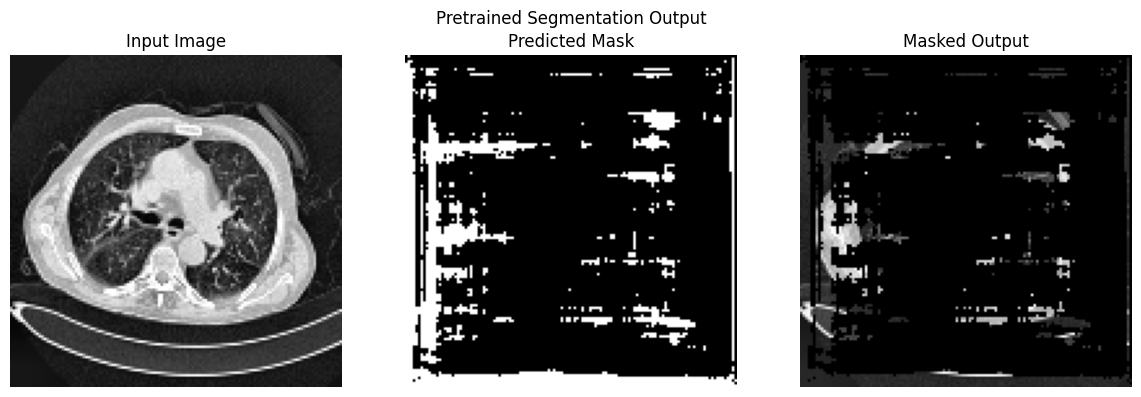

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


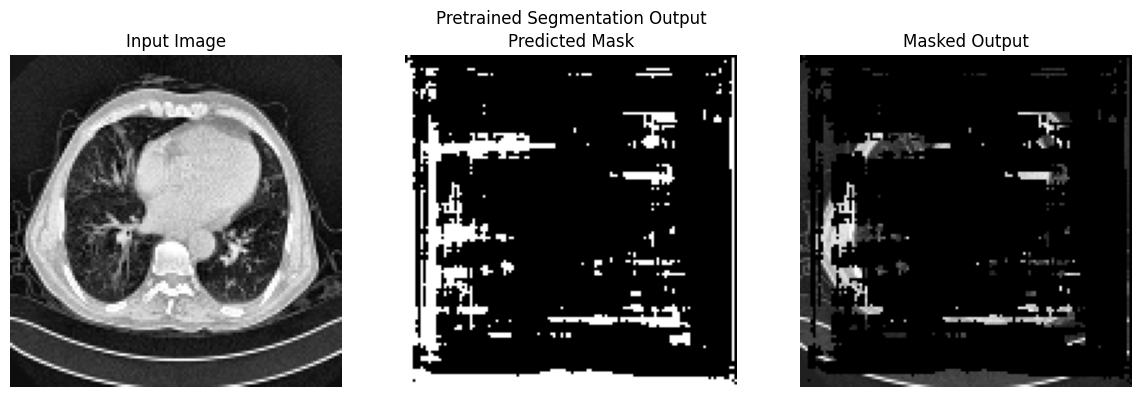

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


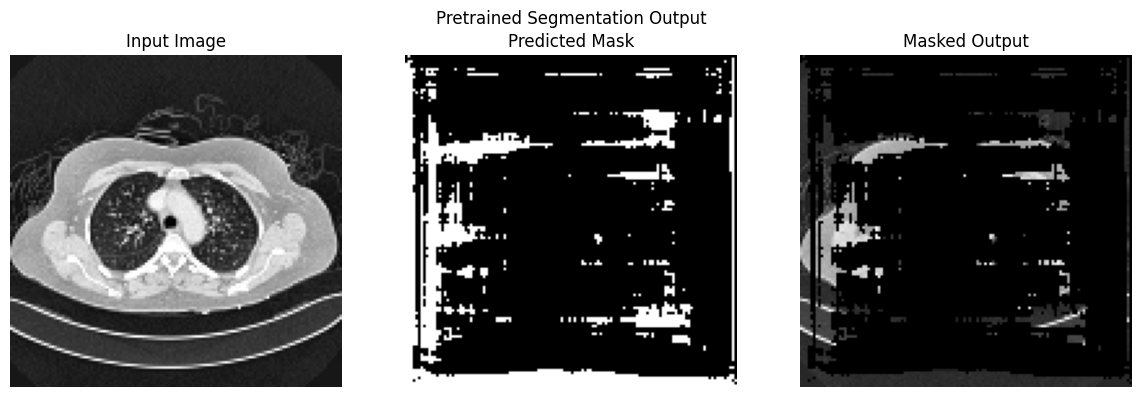

In [ ]:
# -------------------------------
# STEP 3: Pretrained Segmentation as Hard Attention
# -------------------------------
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
seg_model = sm.Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet')

def apply_pretrained_segmentation(img_batch):
    segmented_imgs = []
    for i, img in enumerate(img_batch):
        rgb_img = np.repeat(img, 3, axis=-1)
        rgb_img = preprocess_input(rgb_img)
        pred_mask = seg_model.predict(np.expand_dims(rgb_img, 0))[0, :, :, 0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)
        masked_img = img[:, :, 0] * pred_mask
        segmented_imgs.append(masked_img[..., np.newaxis])

        # ---- Visualization: Segmentation ----
        if i < 3:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img[:, :, 0], cmap='gray')
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(masked_img, cmap='gray')
            plt.title("Masked Output")
            plt.axis("off")
            plt.suptitle("Pretrained Segmentation Output")
            plt.tight_layout()
            plt.show()

    return np.array(segmented_imgs)

print("Applying pretrained segmentation to training and test data...")
X_train_segmented = apply_pretrained_segmentation(X_train)
X_test_segmented = apply_pretrained_segmentation(X_test)

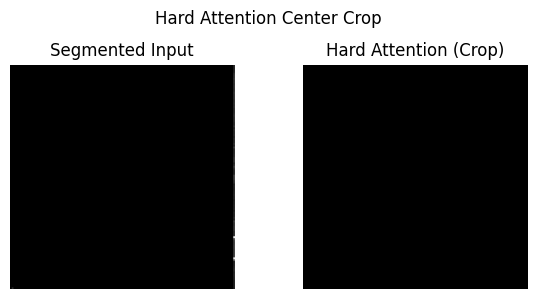

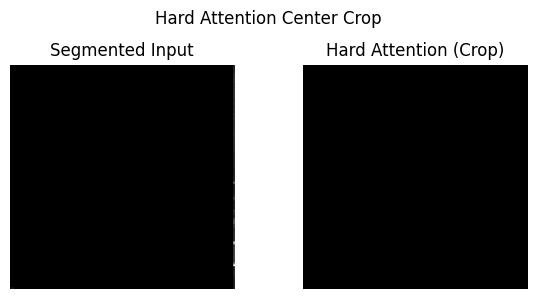

In [ ]:
# -------------------------------
# STEP 4: Hard Attention Crop (Center Glimpse)
# -------------------------------
def hard_attention_glimpse(images, glimpse_size):
    h, w = images.shape[1], images.shape[2]
    start_h = (h - glimpse_size) // 2
    start_w = (w - glimpse_size) // 2
    return images[:, start_h:start_h+glimpse_size, start_w:start_w+glimpse_size, :]

GLIMPSE_SIZE = 124
X_train_glimpse = hard_attention_glimpse(X_train_segmented, GLIMPSE_SIZE)
X_test_glimpse = hard_attention_glimpse(X_test_segmented, GLIMPSE_SIZE)

# ---- Visualization: Center Crop (Hard Attention) ----
for i in range(min(3, len(X_train_glimpse))):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_segmented[i, :, :, 0], cmap='gray')
    plt.title("Segmented Input")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(X_train_glimpse[i, :, :, 0], cmap='gray')
    plt.title("Hard Attention (Crop)")
    plt.axis("off")
    plt.suptitle("Hard Attention Center Crop")
    plt.tight_layout()
    plt.show()

In [ ]:
# -------------------------------
# Model Definition
# -------------------------------
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

def build_attention_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1')(inp)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inp, outputs=out)



In [ ]:
# -------------------------------
# Custom Model with Grad-CAM-based Coherence Loss
# -------------------------------
class AttentionModelWithCoherence(tf.keras.Model):
    def __init__(self, base_model, last_conv_layer_name='conv2', weight=0.5):
        super().__init__()
        self.model = base_model
        self.weight = weight
        self.last_conv_layer_name = last_conv_layer_name
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.accuracy_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

        self.grad_model = tf.keras.Model(
            inputs=self.model.input,
            outputs=[
                self.model.get_layer(self.last_conv_layer_name).output,
                self.model.output
            ]
        )

    def compile(self, optimizer, metrics):
        super().compile()
        self.optimizer = optimizer
        self.metrics_list = metrics

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            conv_outputs, preds = self.grad_model(x)
            class_idx = tf.argmax(preds, axis=-1)
            indices = tf.stack([tf.range(tf.shape(class_idx)[0]), class_idx], axis=1)
            loss = tf.gather_nd(preds, indices)

            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(1, 2))
            heatmaps = tf.reduce_sum(pooled_grads[:, tf.newaxis, tf.newaxis, :] * conv_outputs, axis=-1)
            heatmaps = tf.nn.relu(heatmaps)
            heatmaps = heatmaps / (tf.reduce_sum(heatmaps, axis=(1), keepdims=True) + 1e-10)

        with tf.GradientTape() as full_tape:
            predictions = self.model(x, training=True)
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
            entropy_loss = -tf.reduce_sum(heatmaps * tf.math.log(heatmaps + 1e-10), axis=1)
            total_loss = ce_loss + self.weight * entropy_loss

        grads = full_tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.accuracy_tracker.update_state(y, predictions)

        # ---- Visualization: Grad-CAM ----
        sample_idx = 0
        sample_img = x[sample_idx:sample_idx+1]
        conv_output, prediction = self.grad_model(sample_img)
        pred_class = tf.argmax(prediction, axis=-1).numpy()[0]

        grad = tf.gradients(prediction[:, pred_class], conv_output)[0]
        pooled_grad = tf.reduce_mean(grad, axis=(1, 2))
        heatmap = tf.reduce_sum(pooled_grad[:, tf.newaxis, tf.newaxis, :] * conv_output, axis=-1)[0]
        heatmap = tf.nn.relu(heatmap)
        heatmap /= tf.reduce_max(heatmap) + 1e-8

        plt.imshow(sample_img[0, :, :, 0], cmap='gray')
        plt.imshow(heatmap.numpy(), cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Coherence Visualization")
        plt.axis("off")
        plt.show()

        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    def test_step(self, data):
        x, y = data
        predictions = self.model(x, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y, predictions)
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

In [ ]:
# -------------------------------
# Compile and Train Model
# -------------------------------
base_model = build_attention_base(GLIMPSE_SIZE, len(le.classes_))
model = AttentionModelWithCoherence(base_model, last_conv_layer_name='conv4', weight=0.5)

model.compile(optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(X_train_glimpse, y_train, epochs=5, batch_size=32, validation_split=0.2)

# -------------------------------
# Evaluation
# -------------------------------
model.evaluate(X_test_glimpse, y_test)

Epoch 1/5


TypeError: Tensors in list passed to 'values' of 'Pack' Op have types [int32, int64] that don't all match.

In [ ]:
# ===============================
# STEP 1: Imports and Configuration
# ===============================
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
import segmentation_models as sm

sm.set_framework('tf.keras')
from tensorflow.keras.backend import set_image_data_format
set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
# ===============================
# STEP 2: CLAHE Preprocessing
# ===============================
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return clahe.apply(img) if img is not None else None

# ===============================
# STEP 3: Load and Preprocess Dataset
# ===============================
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
preprocessed_images = []

for subdir in subdirs:
    folder_path = os.path.join(data_dir, subdir)
    for image_path in glob(os.path.join(folder_path, "*.jpg")):
        processed_img = apply_clahe(image_path)
        if processed_img is not None:
            preprocessed_images.append((cv2.resize(processed_img, (128, 128)), subdir))

X = np.array([img for img, _ in preprocessed_images]).astype("float32") / 255.0
X = np.expand_dims(X, -1)
y = [label for _, label in preprocessed_images]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [ ]:
# ===============================
# STEP 4: Pretrained Segmentation
# ===============================
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
seg_model = sm.Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet')

def apply_pretrained_segmentation(img_batch):
    segmented_imgs = []
    for img in img_batch:
        rgb_img = preprocess_input(np.repeat(img, 3, axis=-1))
        pred_mask = seg_model.predict(np.expand_dims(rgb_img, 0))[0, :, :, 0]
        masked_img = img[:, :, 0] * (pred_mask > 0.5).astype(np.float32)
        segmented_imgs.append(masked_img[..., np.newaxis])
    return np.array(segmented_imgs)

X_train_seg = apply_pretrained_segmentation(X_train)
X_test_seg = apply_pretrained_segmentation(X_test)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1

In [ ]:
# ===============================
# STEP 5: Hard Attention (Center Crop)
# ===============================
def hard_attention_glimpse(images, glimpse_size):
    h, w = images.shape[1:3]
    start_h, start_w = (h - glimpse_size) // 2, (w - glimpse_size) // 2
    return images[:, start_h:start_h+glimpse_size, start_w:start_w+glimpse_size, :]

GLIMPSE_SIZE = 124
X_train_glimpse = hard_attention_glimpse(X_train_seg, GLIMPSE_SIZE)
X_test_glimpse = hard_attention_glimpse(X_test_seg, GLIMPSE_SIZE)

In [ ]:
# ===============================
# STEP 6: CNN Base Model
# ===============================
def build_attention_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, 3, activation='relu', padding='same', name='conv1')(inp)
    x = MaxPooling2D(2)(x)
    x = Conv2D(32, 3, activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 3, activation='relu', padding='same', name='conv3')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 3, activation='relu', padding='same', name='conv4')(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

base_model = build_attention_base(GLIMPSE_SIZE, len(le.classes_))
base_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 124, 124, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 124, 124, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 62, 62, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,703,811 (6.50 MB)

 Trainable params: 1,703,811 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.4853 - loss: 1.0102 - val_accuracy: 0.6193 - val_loss: 0.8780
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6655 - loss: 0.8397 - val_accuracy: 0.6932 - val_loss: 0.7077
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6974 - loss: 0.7053 - val_accuracy: 0.7273 - val_loss: 0.6264
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7417 - loss: 0.5807 - val_accuracy: 0.7614 - val_loss: 0.5778
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8032 - loss: 0.4941 - val_accuracy: 0.7898 - val_loss: 0.5356
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8526 - loss: 0.3900 - val_accuracy: 0.8068 - val_loss: 0.4591
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8942 - loss: 0.2848 - val_accuracy: 0.7784 - val_loss: 0.5796
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8661 - loss: 0.2892 - val_accuracy: 0

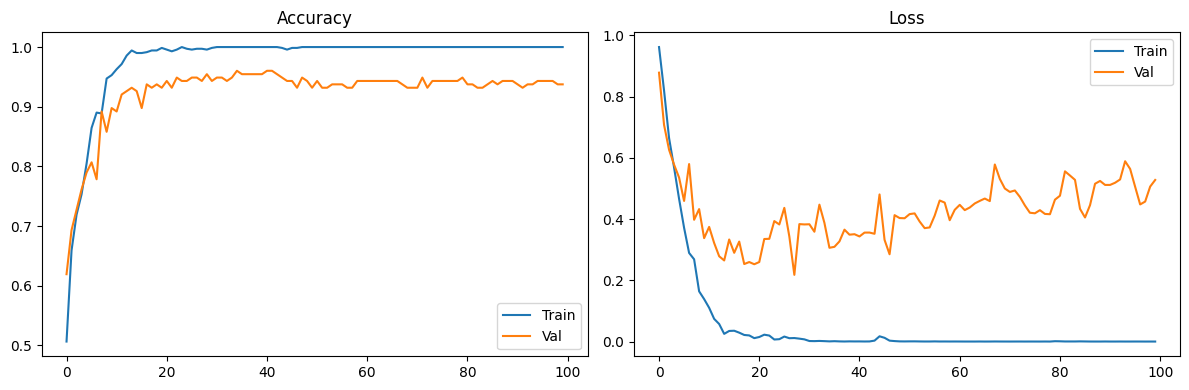

In [ ]:
# ===============================
# STEP 7: Train and Evaluate
# ===============================
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_train_glimpse, y_train, validation_split=0.2, epochs=100, batch_size=32)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

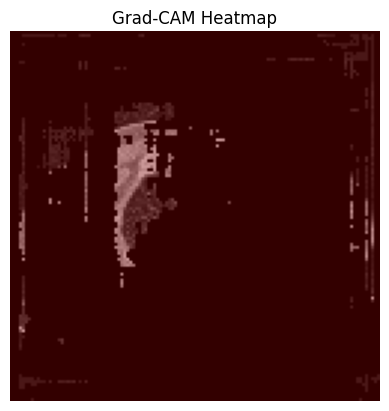

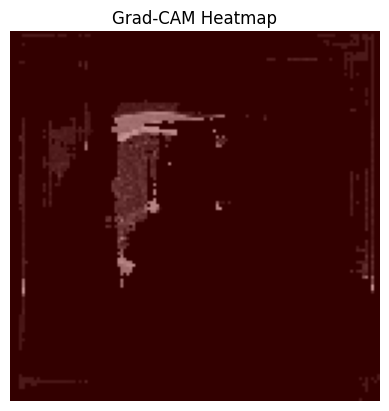

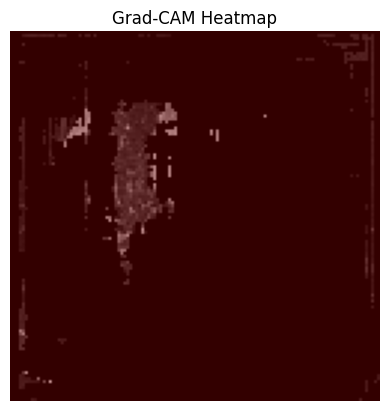

In [ ]:
# ===============================
# STEP 8: Grad-CAM Visualization
# ===============================
def generate_grad_cam(model, image, layer_name='conv2'):
    grad_model = tf.keras.Model([model.input], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, 0))
        pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]
    grads = tape.gradient(class_output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-2)
    return heatmap.numpy()

def overlay_gradcam(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    image = np.repeat(image, 3, axis=-1) if image.shape[-1] == 1 else image
    superimposed = cv2.addWeighted(np.uint8(image * 255), 0.6, heatmap, 0.4, 0)
    return superimposed

# Visualize few test Grad-CAMs
for i in range(3):
    heatmap = generate_grad_cam(base_model, X_test_glimpse[i])
    result = overlay_gradcam(X_test_glimpse[i], heatmap)
    plt.imshow(result)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()


In [ ]:
# ===============================
# STEP 9: Traditional Classifiers + ROC
# ===============================
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(index=-3).output)
features_train = feature_extractor.predict(X_train_glimpse)
features_test = feature_extractor.predict(X_test_glimpse)

classifiers = {
    'GNB': GaussianNB(),
    'SVM': SVC(probability=True),
    'RF': RandomForestClassifier(n_estimators=100),
    'GBM': GradientBoostingClassifier(n_estimators=100)
}

for name, clf in classifiers.items():
    clf.fit(features_train, y_train)
    y_pred = clf.predict(features_test)
    print(f"\n=== {name} Report ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Ensemble
ensemble = VotingClassifier(estimators=list(classifiers.items()), voting='soft')
ensemble.fit(features_train, y_train)
y_pred_ensemble = ensemble.predict(features_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step

=== GNB Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.88      0.93        24
Malignant cases       0.97      0.99      0.98       113
   Normal cases       0.96      0.98      0.97        83

       accuracy                           0.97       220
      macro avg       0.98      0.95      0.96       220
   weighted avg       0.97      0.97      0.97       220


=== SVM Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       0.99      0.99      0.99       113
   Normal cases       0.98      0.99      0.98        83

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.98       220
   weighted avg       0.99      0.99      0.99       220


=== RF Report ===
                 precision    recall  f1-score   support



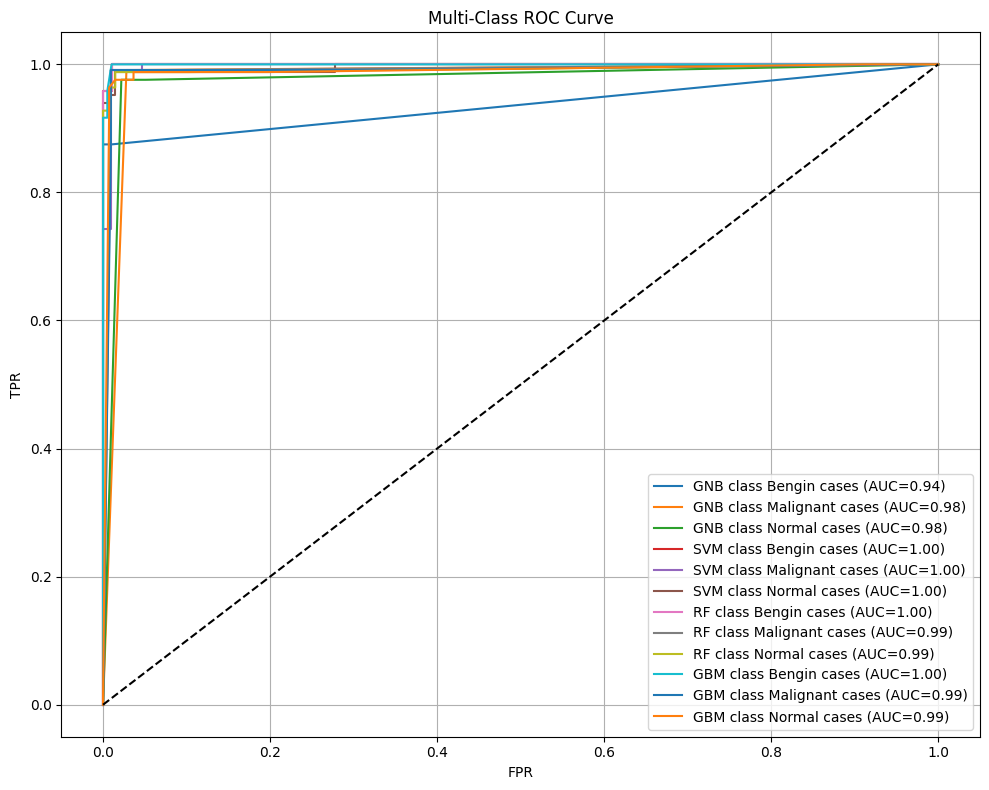

In [ ]:
# ===============================
# STEP 10: ROC Curve Plot
# ===============================
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
for name, clf in classifiers.items():
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(features_test)
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} class {le.classes_[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------
# STEP 1: Imports and CLAHE
# -------------------------------
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import segmentation_models as sm

sm.set_framework('tf.keras')
from tensorflow.keras.backend import set_image_data_format
set_image_data_format('channels_last')

# CLAHE for grayscale enhancement
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None
    return clahe.apply(img)

# -------------------------------
# STEP 2: Load and Preprocess Dataset
# -------------------------------
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
preprocessed_images = []

for subdir in subdirs:
    folder_path = os.path.join(data_dir, subdir)
    image_paths = glob(os.path.join(folder_path, "*.jpg"))
    for image_path in image_paths:
        processed_img = apply_clahe(image_path)
        if processed_img is not None:
            preprocessed_images.append((processed_img, subdir))

IMG_SIZE = 128
X, y = [], []

for img, label in preprocessed_images:
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(resized)
    y.append(label)

X = np.array(X).astype("float32") / 255.0
X = np.expand_dims(X, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# -------------------------------
# STEP 3: Pretrained Segmentation as Hard Attention
# -------------------------------
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
seg_model = sm.Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet')

def apply_pretrained_segmentation(img_batch):
    segmented_imgs = []
    for img in img_batch:
        rgb_img = np.repeat(img, 3, axis=-1)  # convert grayscale to 3 channels
        rgb_img = preprocess_input(rgb_img)
        pred_mask = seg_model.predict(np.expand_dims(rgb_img, 0))[0, :, :, 0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)
        masked_img = img[:, :, 0] * pred_mask
        segmented_imgs.append(masked_img[..., np.newaxis])
    return np.array(segmented_imgs)

print("Applying pretrained segmentation to training and test data...")
X_train_segmented = apply_pretrained_segmentation(X_train)
X_test_segmented = apply_pretrained_segmentation(X_test)

# -------------------------------
# STEP 4: Hard Attention Crop (Center Glimpse)
# -------------------------------
def hard_attention_glimpse(images, glimpse_size):
    h, w = images.shape[1], images.shape[2]
    start_h = (h - glimpse_size) // 2
    start_w = (w - glimpse_size) // 2
    return images[:, start_h:start_h+glimpse_size, start_w:start_w+glimpse_size, :]

GLIMPSE_SIZE = 124
X_train_glimpse = hard_attention_glimpse(X_train_segmented, GLIMPSE_SIZE)
X_test_glimpse = hard_attention_glimpse(X_test_segmented, GLIMPSE_SIZE)


Applying pretrained segmentation to training and test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

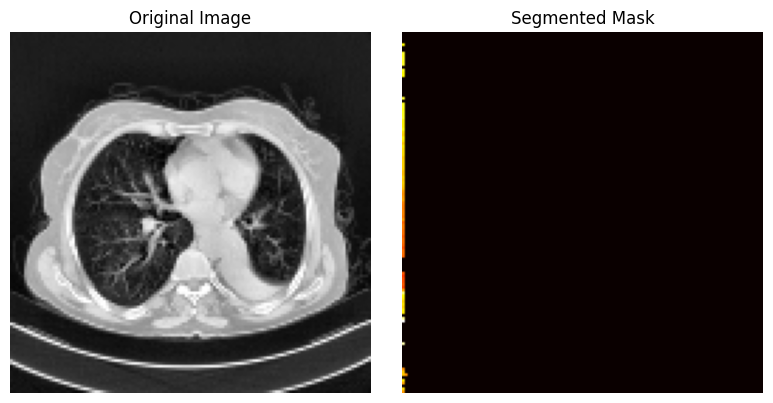

In [ ]:
def visualize_segmentation(original, segmented, index=0):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original[index].squeeze(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(segmented[index].squeeze(), cmap='hot')
    axes[1].set_title("Segmented Mask")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_segmentation(X_train, X_train_segmented, index=5)


In [ ]:
# -------------------------------
# STEP 2: Hard Attention (Center Crop)
# -------------------------------
def hard_attention_glimpse(images, glimpse_size):
    h, w = images.shape[1], images.shape[2]
    start_h = (h - glimpse_size) // 2
    start_w = (w - glimpse_size) // 2
    return images[:, start_h:start_h+glimpse_size, start_w:start_w+glimpse_size, :]

GLIMPSE_SIZE = 124
X_train_glimpse = hard_attention_glimpse(X_train, GLIMPSE_SIZE)
X_test_glimpse = hard_attention_glimpse(X_test, GLIMPSE_SIZE)

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

def build_attention_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1')(inp)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inp, outputs=out)

# -------------------------------
# STEP 4: Custom Model with Coherence Loss (Grad-CAM)
# -------------------------------
class AttentionModelWithCoherence(tf.keras.Model):
    def __init__(self, base_model, last_conv_layer_name='conv2', weight=0.5):
        super().__init__()
        self.model = base_model
        self.weight = weight
        self.last_conv_layer_name = last_conv_layer_name
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.accuracy_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

        # Grad model to get conv features + predictions
        self.grad_model = tf.keras.Model(
            inputs=self.model.input,
            outputs=[
                self.model.get_layer(self.last_conv_layer_name).output,
                self.model.output
            ]
        )

    def compile(self, optimizer, metrics):
        super().compile()
        self.optimizer = optimizer
        self.metrics_list = metrics

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            conv_outputs, preds = self.grad_model(x)
            class_idx = tf.argmax(preds, axis=-1)
            indices = tf.stack([
                tf.range(tf.shape(class_idx)[0], dtype=tf.int64),
                tf.cast(class_idx, tf.int64)
            ], axis=1)
            loss = tf.gather_nd(preds, indices)

            # Gradients w.r.t. conv outputs
            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

            heatmaps = tf.reduce_sum(tf.multiply(pooled_grads[:, tf.newaxis, tf.newaxis, :], conv_outputs), axis=-1)
            heatmaps = tf.nn.relu(heatmaps)
            heatmaps = tf.reshape(heatmaps, [tf.shape(heatmaps)[0], -1])
            heatmaps = heatmaps / (tf.reduce_sum(heatmaps, axis=1, keepdims=True) + 1e-10)

        with tf.GradientTape() as full_tape:
            predictions = self.model(x, training=True)
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
            entropy_loss = -tf.reduce_sum(heatmaps * tf.math.log(heatmaps + 1e-10), axis=1)
            total_loss = ce_loss + self.weight * entropy_loss

        gradients = full_tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.accuracy_tracker.update_state(y, predictions)
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    def test_step(self, data):
        x, y = data
        predictions = self.model(x, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y, predictions)
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

# -------------------------------
# STEP 5: Compile and Train
# -------------------------------
base_model = build_attention_base(GLIMPSE_SIZE, len(le.classes_))
model = AttentionModelWithCoherence(base_model, last_conv_layer_name='conv4', weight=0.5)

model.compile(optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(X_train_glimpse, y_train, epochs=150, batch_size=32, validation_split=0.2)

# -------------------------------
# STEP 6: Evaluation
# -------------------------------
model.evaluate(X_test_glimpse, y_test)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report

# Feature extractor from base_model (3rd last layer before softmax)
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(index=-3).output)

# Extract features
features_train = feature_extractor.predict(X_train_glimpse)
features_test = feature_extractor.predict(X_test_glimpse)

# Classifier 1: Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(features_train, y_train)
y_pred_gnb = gnb.predict(features_test)
print("=== GNB Classification Report ===")
print(classification_report(y_test, y_pred_gnb, target_names=le.classes_))

# Classifier 2: Support Vector Machine
svm = SVC(probability=True)
svm.fit(features_train, y_train)
y_pred_svm = svm.predict(features_test)
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Classifier 3: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_train, y_train)
y_pred_rf = rf.predict(features_test)
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Classifier 4: Gradient Boosting
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(features_train, y_train)
y_pred_gbm = gbm.predict(features_test)
print("=== Gradient Boosting Classification Report ===")
print(classification_report(y_test, y_pred_gbm, target_names=le.classes_))

# Ensemble Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('gnb', gnb),
    ('svm', svm),
    ('rf', rf),
    ('gbm', gbm)
], voting='soft')  # Use 'soft' for probability averaging

ensemble.fit(features_train, y_train)
y_pred_ensemble = ensemble.predict(features_test)
print("=== Ensemble Voting Classification Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))




Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.4944 - loss: 3.6056 - val_accuracy: 0.5625 - val_loss: 0.9092
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6379 - loss: 3.1608 - val_accuracy: 0.7216 - val_loss: 0.7010
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7479 - loss: 3.0361 - val_accuracy: 0.7443 - val_loss: 0.6216
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7913 - loss: 2.8988 - val_accuracy: 0.8295 - val_loss: 0.4413
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8512 - loss: 2.8365 - val_accuracy: 0.8750 - val_loss: 0.3177
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8866 - loss: 2.6902 - val_accuracy: 0.8693 - val_loss: 0.2985
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9172 - loss: 2.6468 - val_accuracy: 0.9091 - val_loss: 0.2163
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9575 - loss: 2.5167 - val_accuracy: 0

=== GaussianNB Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.92      0.96        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.98      0.99      0.98        83

       accuracy                           0.99       220
      macro avg       0.99      0.97      0.98       220
   weighted avg       0.99      0.99      0.99       220



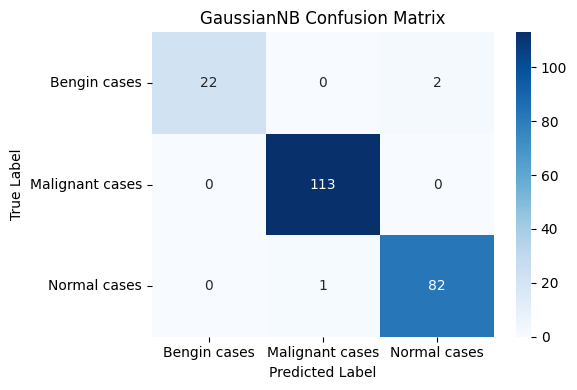

=== SVM Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.99      0.99      0.99        83

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.99       220
   weighted avg       0.99      0.99      0.99       220



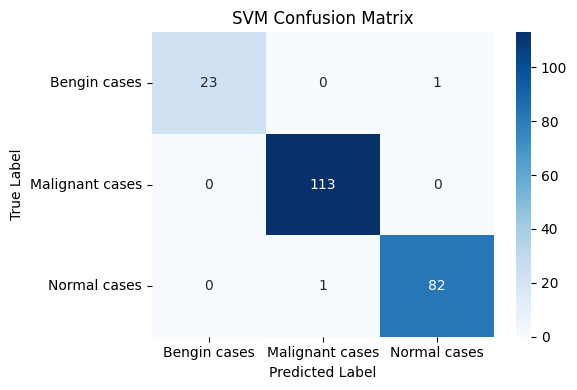

=== Random Forest Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.99      0.99      0.99        83

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.99       220
   weighted avg       0.99      0.99      0.99       220



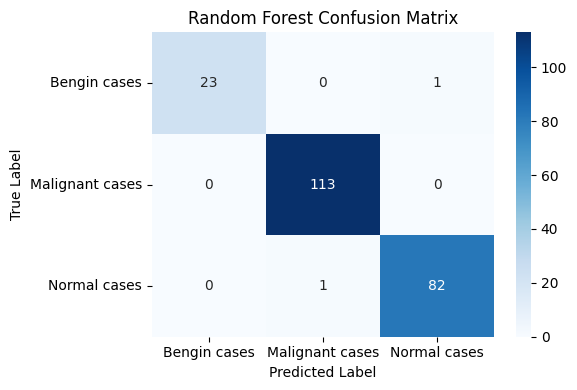

=== Gradient Boosting Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.99      0.99      0.99        83

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.99       220
   weighted avg       0.99      0.99      0.99       220



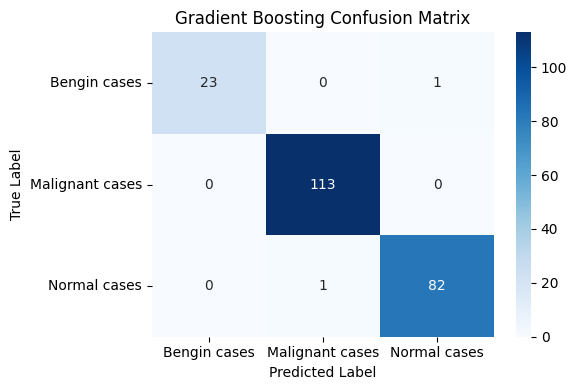

=== Ensemble Voting Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.99      0.99      0.99        83

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.99       220
   weighted avg       0.99      0.99      0.99       220



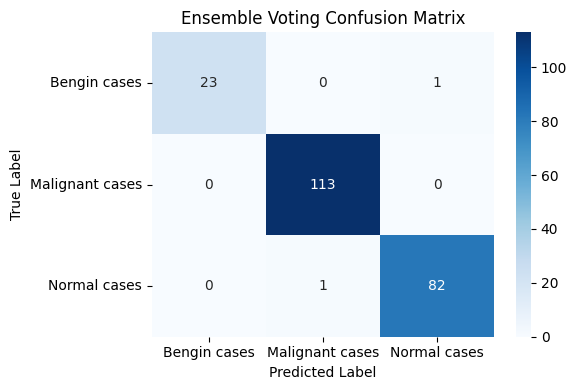

In [ ]:
classifiers = {
    "GaussianNB": gnb,
    "SVM": svm,
    "Random Forest": rf,
    "Gradient Boosting": gbm,
    "Ensemble Voting": ensemble
}

predictions = {
    "GaussianNB": y_pred_gnb,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gbm,
    "Ensemble Voting": y_pred_ensemble
}

# Store scores for plotting
accuracies = {}
f1_scores = {}

for name, clf in classifiers.items():
    y_pred = predictions[name]

    # Classification report
    print(f"=== {name} Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"{name}_confusion_matrix.png")  # Save figure for paper
    plt.show()

    # Accuracy and F1-score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracies[name] = acc
    f1_scores[name] = f1


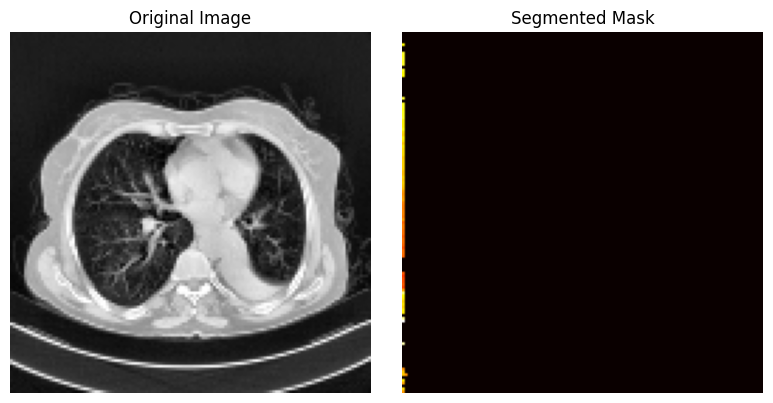

In [ ]:
def visualize_segmentation(original, segmented, index=0):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original[index].squeeze(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(segmented[index].squeeze(), cmap='hot')
    axes[1].set_title("Segmented Mask")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_segmentation(X_train, X_train_segmented, index=5)


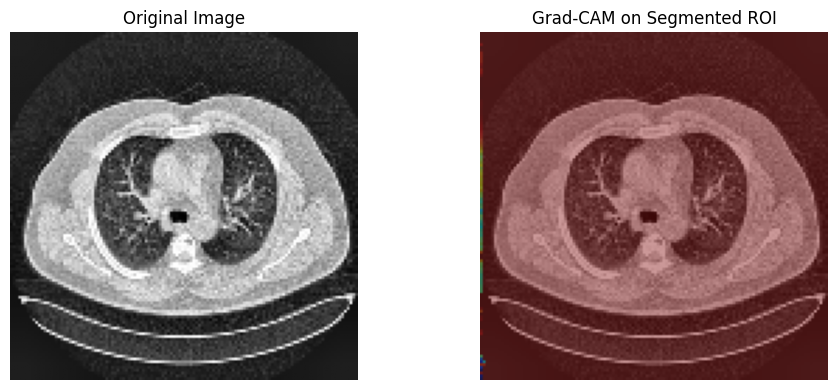

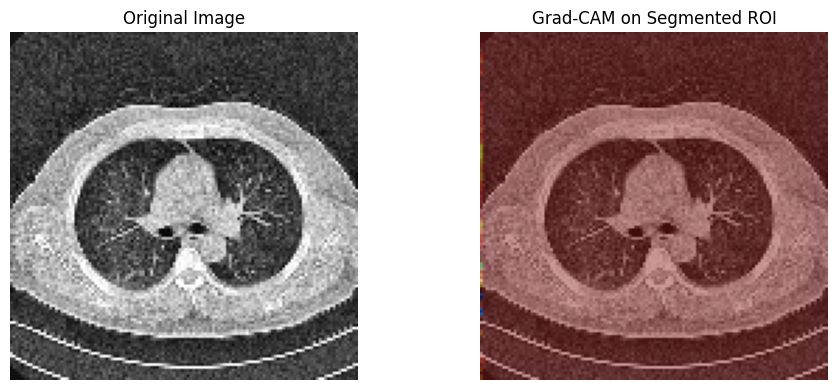

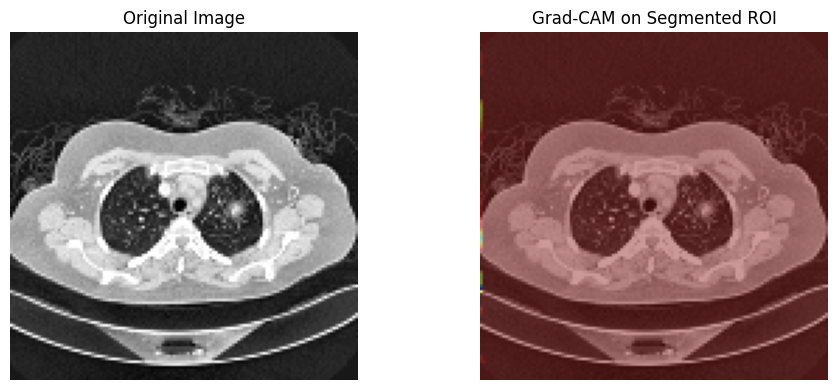

In [ ]:
# def generate_grad_cam_heatmap(model, image, last_conv_layer_name='conv3'):
#     grad_model = tf.keras.Model(
#         [model.input],
#         [model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(image_tensor)
#         pred_index = tf.argmax(predictions[0])
#         class_channel = predictions[:, pred_index]

#     grads = tape.gradient(class_channel, conv_outputs)[0]
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
#     conv_outputs = conv_outputs[0]
#     heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
#     heatmap = np.maximum(heatmap, 0)
#     heatmap = heatmap / (np.max(heatmap) + 1e-20)
#     return heatmap


# def overlay_heatmap(heatmap, image):
#     heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
#     heatmap_resized = np.uint8(255 * heatmap_resized)
#     heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
#     if image.shape[-1] == 1:
#         image = np.repeat(image, 3, axis=-1)
#     superimposed_img = cv2.addWeighted(np.uint8(image * 255), 0.6, heatmap_color, 0.4, 0)
#     return superimposed_img

# # Show Grad-CAM for a few test images
# for i in range(3):
#     img = X_test_glimpse[i]
#     heatmap = generate_grad_cam_heatmap(model.model, img)
#     overlay = overlay_heatmap(heatmap, img)
#     plt.figure(figsize=(5, 4))
#     plt.imshow(overlay)
#     plt.title("Grad-CAM Heatmap Overlay")
#     plt.axis('off')
#     plt.show()


def generate_grad_cam_heatmap(model, image, last_conv_layer_name='conv4'):
    grad_model = tf.keras.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_tensor)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    return heatmap


def overlay_segmented_heatmap(heatmap, image, segmentation_mask):
    # Resize heatmap and segmentation to match original image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    segmentation_mask_resized = cv2.resize(segmentation_mask.squeeze(), (image.shape[1], image.shape[0]))

    # Apply segmentation mask to heatmap
    masked_heatmap = heatmap_resized * segmentation_mask_resized
    masked_heatmap = np.uint8(255 * masked_heatmap / (np.max(masked_heatmap) + 1e-8))
    heatmap_color = cv2.applyColorMap(masked_heatmap, cv2.COLORMAP_JET)

    # Prepare grayscale image to 3-channel
    if image.shape[-1] == 1:
        image_rgb = np.repeat(image, 3, axis=-1)
    else:
        image_rgb = image

    superimposed_img = cv2.addWeighted(np.uint8(image_rgb * 255), 0.6, heatmap_color, 0.4, 0)
    return superimposed_img


# -------------------------------
# Visualize: Original vs Grad-CAM on Segmented Area
# -------------------------------
for i in range(3):
    img = X_test_glimpse[i]
    seg_mask = X_test_segmented[i]

    heatmap = generate_grad_cam_heatmap(model.model, img)
    overlay = overlay_segmented_heatmap(heatmap, img, seg_mask)

    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(overlay)
    axs[1].set_title("Grad-CAM on Segmented ROI")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()



Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9906 - loss: 2.3604 - val_accuracy: 0.9716 - val_loss: 0.1135
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9988 - loss: 2.1934 - val_accuracy: 0.9830 - val_loss: 0.1334
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9969 - loss: 1.7695 - val_accuracy: 0.9773 - val_loss: 0.1198
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1239 - val_accuracy: 0.9545 - val_loss: 0.1659
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 2.0910 - val_accuracy: 0.9716 - val_loss: 0.1330
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9974 - loss: 1.7490 - val_accuracy: 0.9659 - val_loss: 0.1422
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.0484 - val_accuracy: 0.9716 - val_loss: 0.1552
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.8164 - val_accuracy: 0.

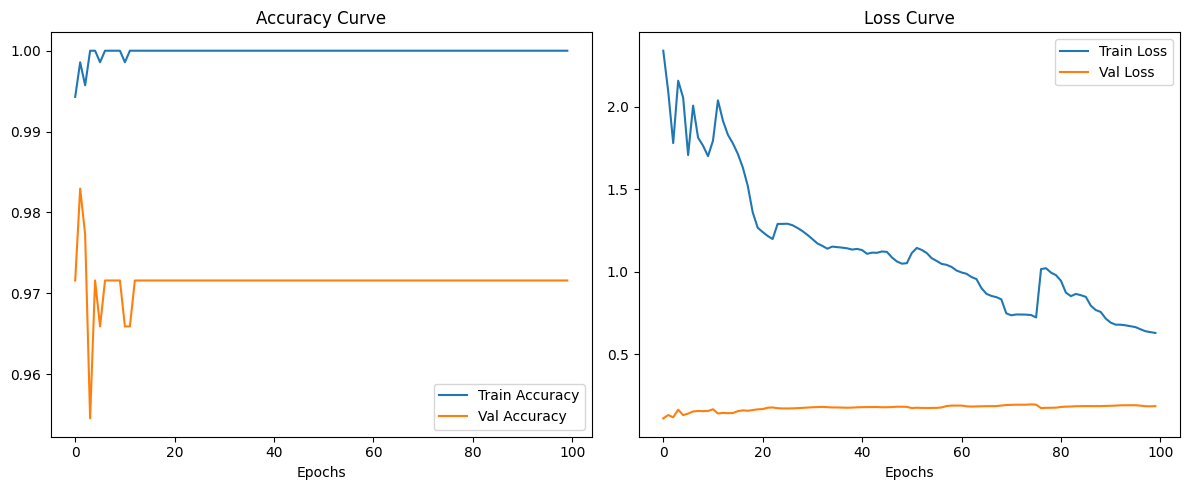

In [ ]:
history = model.fit(
    X_train_glimpse, y_train,
    epochs=100, batch_size=32,
    validation_split=0.2
)

# Plot Accuracy and Loss
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.xlabel("Epochs")

    plt.tight_layout()
    plt.show()

plot_training_curves(history)


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test_glimpse.reshape(X_test_glimpse.shape[0], -1))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f"{name} class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig("ROC_Curves.png")
plt.show()


ValueError: X has 15376 features, but GaussianNB is expecting 256 features as input.

<Figure size 1000x800 with 0 Axes>

In [ ]:
# -------------------------------
# STEP 1: Imports and Preprocessing
# -------------------------------
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# CLAHE setup
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))

def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None
    return clahe.apply(img)

# Load dataset
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
preprocessed_images = []

for subdir in subdirs:
    folder_path = os.path.join(data_dir, subdir)
    image_paths = glob(os.path.join(folder_path, "*.jpg"))
    for image_path in image_paths:
        processed_img = apply_clahe(image_path)
        if processed_img is not None:
            preprocessed_images.append((processed_img, subdir))

# Resize and prepare data
IMG_SIZE = 128
X, y = [], []

for img, label in preprocessed_images:
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(resized)
    y.append(label)

X = np.array(X).astype("float32") / 255.0
X = np.expand_dims(X, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
# -------------------------------
# STEP 2: Hard Attention (Center Crop)
# -------------------------------
def hard_attention_glimpse(images, glimpse_size):
    h, w = images.shape[1], images.shape[2]
    start_h = (h - glimpse_size) // 2
    start_w = (w - glimpse_size) // 2
    return images[:, start_h:start_h+glimpse_size, start_w:start_w+glimpse_size, :]

GLIMPSE_SIZE = 124
X_train_glimpse = hard_attention_glimpse(X_train, GLIMPSE_SIZE)
X_test_glimpse = hard_attention_glimpse(X_test, GLIMPSE_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

def build_attention_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1')(inp)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inp, outputs=out)

In [ ]:
# -------------------------------
# STEP 4: Custom Model with Coherence Loss (Grad-CAM)
# -------------------------------
class AttentionModelWithCoherence(tf.keras.Model):
    def __init__(self, base_model, last_conv_layer_name='conv2', weight=0.5):
        super().__init__()
        self.model = base_model
        self.weight = weight
        self.last_conv_layer_name = last_conv_layer_name
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.accuracy_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

        # Grad model to get conv features + predictions
        self.grad_model = tf.keras.Model(
            inputs=self.model.input,
            outputs=[
                self.model.get_layer(self.last_conv_layer_name).output,
                self.model.output
            ]
        )

    def compile(self, optimizer, metrics):
        super().compile()
        self.optimizer = optimizer
        self.metrics_list = metrics

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            conv_outputs, preds = self.grad_model(x)
            class_idx = tf.argmax(preds, axis=-1)
            indices = tf.stack([
                tf.range(tf.shape(class_idx)[0], dtype=tf.int64),
                tf.cast(class_idx, tf.int64)
            ], axis=1)
            loss = tf.gather_nd(preds, indices)

            # Gradients w.r.t. conv outputs
            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

            heatmaps = tf.reduce_sum(tf.multiply(pooled_grads[:, tf.newaxis, tf.newaxis, :], conv_outputs), axis=-1)
            heatmaps = tf.nn.relu(heatmaps)
            heatmaps = tf.reshape(heatmaps, [tf.shape(heatmaps)[0], -1])
            heatmaps = heatmaps / (tf.reduce_sum(heatmaps, axis=1, keepdims=True) + 1e-10)

        with tf.GradientTape() as full_tape:
            predictions = self.model(x, training=True)
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
            entropy_loss = -tf.reduce_sum(heatmaps * tf.math.log(heatmaps + 1e-10), axis=1)
            total_loss = ce_loss + self.weight * entropy_loss

        gradients = full_tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.accuracy_tracker.update_state(y, predictions)
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    def test_step(self, data):
        x, y = data
        predictions = self.model(x, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y, predictions)
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

In [ ]:
# -------------------------------
# STEP 5: Compile and Train
# -------------------------------
base_model = build_attention_base(GLIMPSE_SIZE, len(le.classes_))
model = AttentionModelWithCoherence(base_model, last_conv_layer_name='conv4', weight=0.5)

model.compile(optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(X_train_glimpse, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.4983 - loss: 3.6459 - val_accuracy: 0.5000 - val_loss: 0.9289
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5987 - loss: 3.3477 - val_accuracy: 0.6534 - val_loss: 0.7941
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6760 - loss: 3.1120 - val_accuracy: 0.6761 - val_loss: 0.7491
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7899 - loss: 3.0188 - val_accuracy: 0.8068 - val_loss: 0.5041
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8295 - loss: 2.8591 - val_accuracy: 0.8182 - val_loss: 0.4278
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8650 - loss: 2.7376 - val_accuracy: 0.8580 - val_loss: 0.3612
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9089 - loss: 2.6983 - val_accuracy: 0.9148 - val_loss: 0.2518
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9275 - loss: 2.5043 - val_accuracy: 0

In [ ]:
# -------------------------------
# STEP 6: Evaluation
# -------------------------------
model.evaluate(X_test_glimpse, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8681 - loss: 0.3670


[0.40365004539489746, 0.8454545736312866]

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report

# Feature extractor from base_model (3rd last layer before softmax)
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(index=-3).output)

# Extract features
features_train = feature_extractor.predict(X_train_glimpse)
features_test = feature_extractor.predict(X_test_glimpse)

# Classifier 1: Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(features_train, y_train)
y_pred_gnb = gnb.predict(features_test)
print("=== GNB Classification Report ===")
print(classification_report(y_test, y_pred_gnb, target_names=le.classes_))

# Classifier 2: Support Vector Machine
svm = SVC(probability=True)
svm.fit(features_train, y_train)
y_pred_svm = svm.predict(features_test)
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Classifier 3: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_train, y_train)
y_pred_rf = rf.predict(features_test)
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Classifier 4: Gradient Boosting
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(features_train, y_train)
y_pred_gbm = gbm.predict(features_test)
print("=== Gradient Boosting Classification Report ===")
print(classification_report(y_test, y_pred_gbm, target_names=le.classes_))

# Ensemble Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('gnb', gnb),
    ('svm', svm),
    ('rf', rf),
    ('gbm', gbm)
], voting='soft')  # Use 'soft' for probability averaging

ensemble.fit(features_train, y_train)
y_pred_ensemble = ensemble.predict(features_test)
print("=== Ensemble Voting Classification Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
=== GNB Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.96      0.92      0.94        24
Malignant cases       0.96      1.00      0.98       113
   Normal cases       1.00      0.95      0.98        83

       accuracy                           0.97       220
      macro avg       0.97      0.96      0.96       220
   weighted avg       0.97      0.97      0.97       220

=== SVM Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.95      0.88      0.91        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.96      0.98      0.97        83

       accuracy                           0.98       220
      macro avg       0.97      0.95      0.96       220
   weighted avg       0.98      0.98      0.98       220

=== Random Forest Classification Report ===
      

=== GaussianNB Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.96      0.92      0.94        24
Malignant cases       0.96      1.00      0.98       113
   Normal cases       1.00      0.95      0.98        83

       accuracy                           0.97       220
      macro avg       0.97      0.96      0.96       220
   weighted avg       0.97      0.97      0.97       220



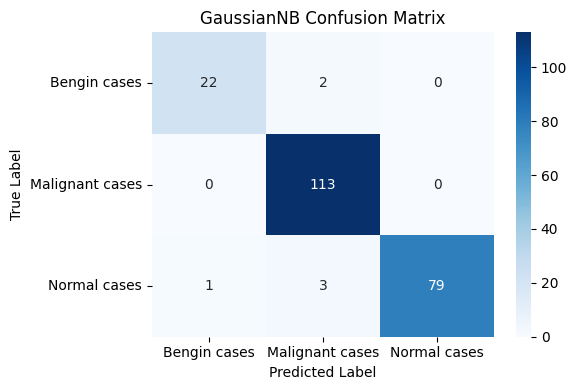

=== SVM Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.95      0.88      0.91        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.96      0.98      0.97        83

       accuracy                           0.98       220
      macro avg       0.97      0.95      0.96       220
   weighted avg       0.98      0.98      0.98       220



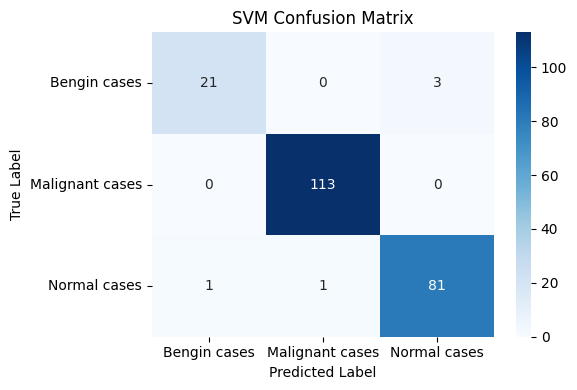

=== Random Forest Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.95      0.88      0.91        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.96      0.98      0.97        83

       accuracy                           0.98       220
      macro avg       0.97      0.95      0.96       220
   weighted avg       0.98      0.98      0.98       220



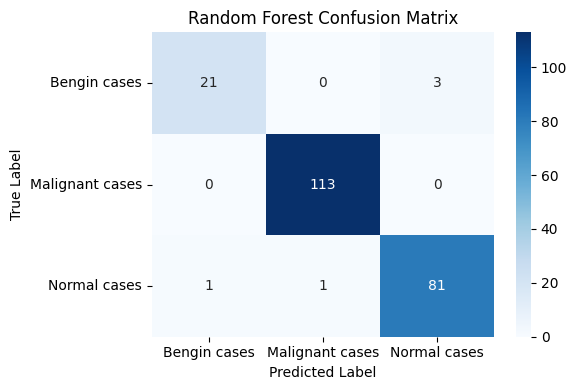

=== Gradient Boosting Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.96      0.96      0.96        24
Malignant cases       0.97      1.00      0.99       113
   Normal cases       1.00      0.96      0.98        83

       accuracy                           0.98       220
      macro avg       0.98      0.97      0.98       220
   weighted avg       0.98      0.98      0.98       220



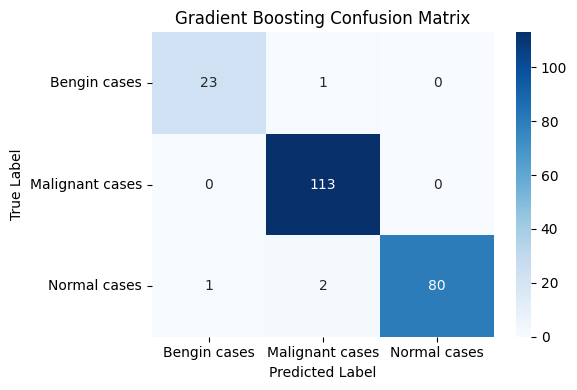

=== Ensemble Voting Classification Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.96      0.96      0.96        24
Malignant cases       0.98      1.00      0.99       113
   Normal cases       1.00      0.98      0.99        83

       accuracy                           0.99       220
      macro avg       0.98      0.98      0.98       220
   weighted avg       0.99      0.99      0.99       220



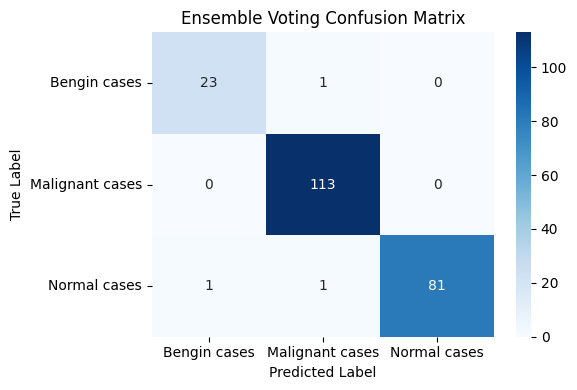

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

classifiers = {
    "GaussianNB": gnb,
    "SVM": svm,
    "Random Forest": rf,
    "Gradient Boosting": gbm,
    "Ensemble Voting": ensemble
}

predictions = {
    "GaussianNB": y_pred_gnb,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gbm,
    "Ensemble Voting": y_pred_ensemble
}

# Store scores for plotting
accuracies = {}
f1_scores = {}

for name, clf in classifiers.items():
    y_pred = predictions[name]

    # Classification report
    print(f"=== {name} Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"{name}_confusion_matrix.png")  # Save figure for paper
    plt.show()

    # Accuracy and F1-score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracies[name] = acc
    f1_scores[name] = f1


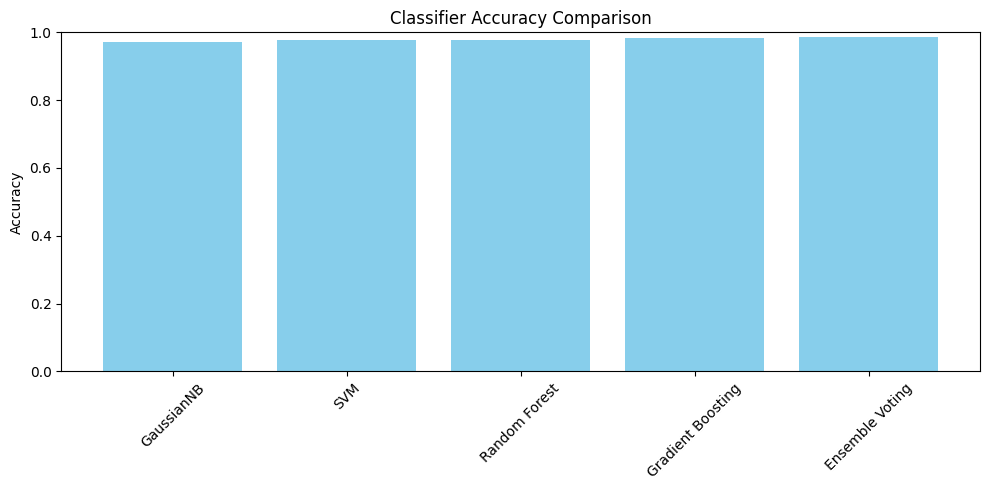

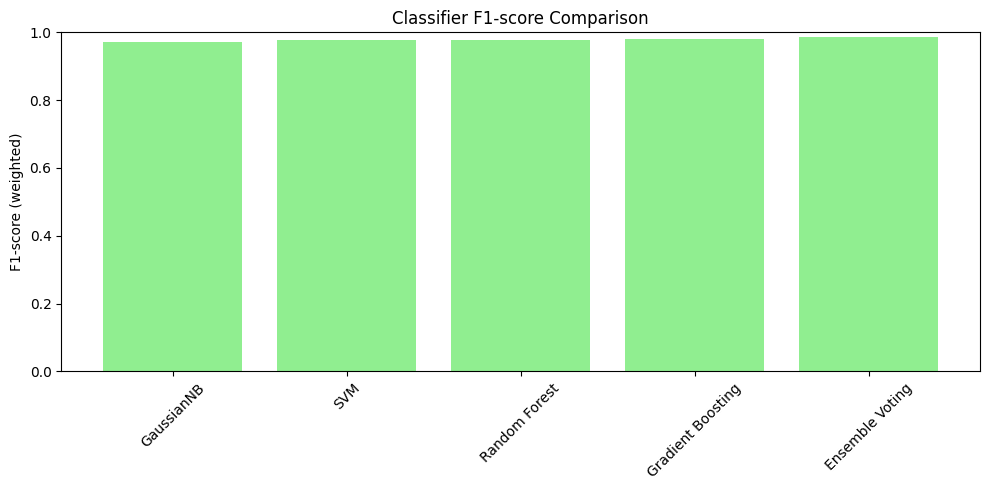

In [ ]:
# Bar chart for accuracy
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title("Classifier Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("classifier_accuracy_comparison.png")
plt.show()

# Bar chart for F1-score
plt.figure(figsize=(10, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='lightgreen')
plt.title("Classifier F1-score Comparison")
plt.ylabel("F1-score (weighted)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("classifier_f1score_comparison.png")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_heatmap(y_true, y_pred, labels, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=labels, yticklabels=labels,
                cbar=True, square=True, linewidths=1, linecolor='gray')
    plt.title(f'Confusion Matrix: {title}', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


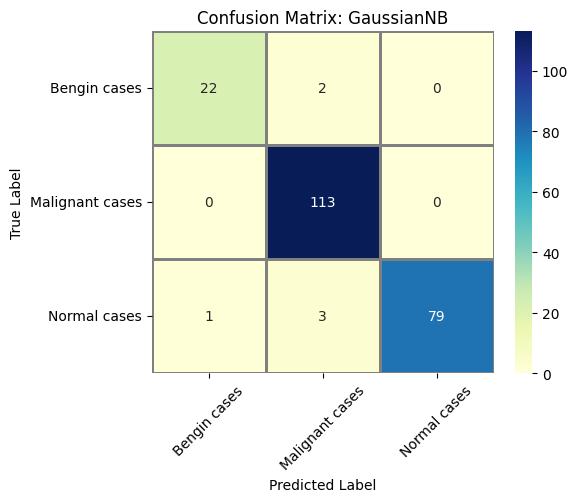

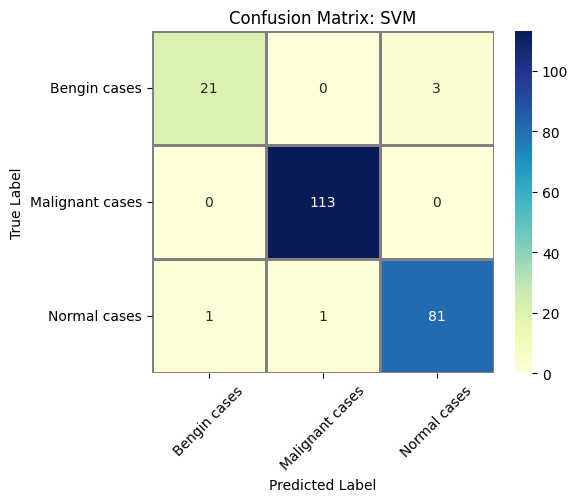

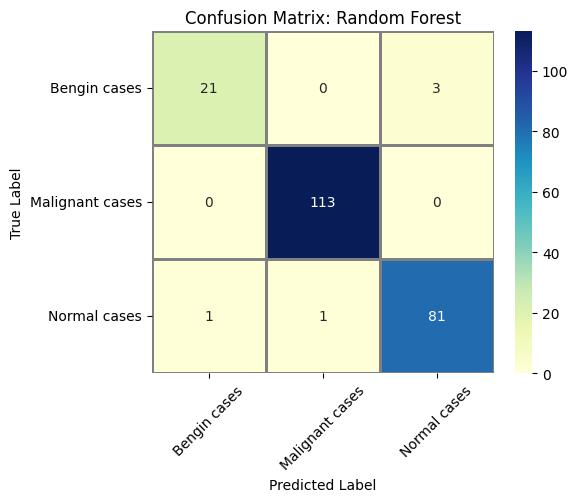

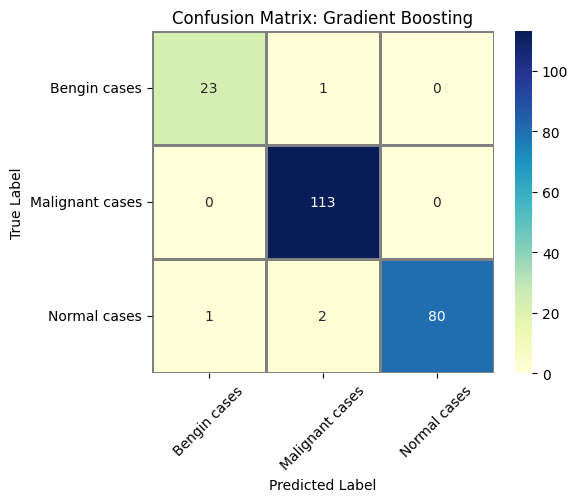

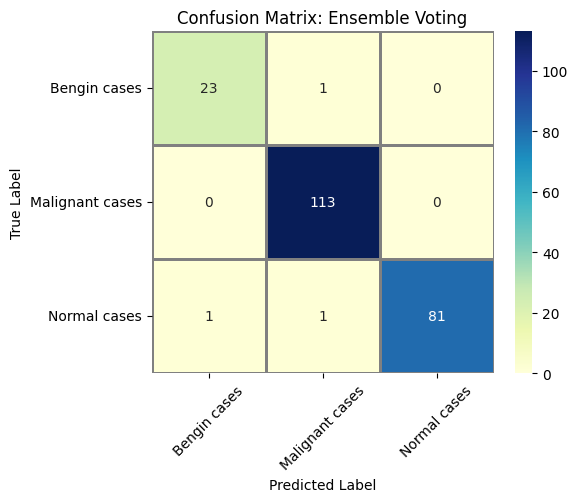

In [ ]:
for name, clf in classifiers.items():
    y_pred = predictions[name]
    plot_confusion_heatmap(y_test, y_pred, labels=le.classes_,
                           title=name,
                           save_path=f"{name}_heatmap.png")
